In [36]:
from pathlib import Path

OUTPUT_ROOTS = [
    Path('../output/longwiki-hybrid'),
    Path('../output/longwiki-hybrid2'),
    Path('../output/longwiki-hybrid300'),
]

LENGTH_FILTER = None  # ex: [50, 150, 300]
TASK_FILTER = None    # ex: ['INTERVIEW', 'NEWS_ARTICLE']
REQUIRE_OUTPUT_CSV = True
STRICT_MATCHING = True
TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

BOOTSTRAP_ITERS = 2000
BOOTSTRAP_SEED = 7


# HalluLens - Analyse correlation hallucination (notebook propre)

Ce notebook construit un **catalogue de runs**, normalise les **prompts** et calcule des **metriques de hallucination** au niveau prompt, puis realise des comparaisons **strictement appariees** (memes prompts ou memes instances) afin d'eviter tout biais de taille d'echantillon ou de prompt sets non comparables.


In [37]:
import os
import json
import hashlib
import itertools
import warnings
from pathlib import Path

# Make matplotlib/fontconfig caches writable (helps in sandboxed envs).
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(ARTIFACTS_DIR / '.mplconfig'))
os.environ.setdefault('XDG_CACHE_HOME', str(ARTIFACTS_DIR / '.cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    HAVE_SNS = True
except Exception as e:
    HAVE_SNS = False
    print('Seaborn unavailable:', e)

warnings.filterwarnings('ignore', message='Pandas requires version')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


In [38]:
from pathlib import Path

OUTPUT_ROOTS = [
    Path('../output/longwiki-hybrid'),
    Path('../output/longwiki-hybrid2'),
    Path('../output/longwiki-hybrid300'),
]

LENGTH_FILTER = None  # ex: [50, 150, 300]
TASK_FILTER = None    # ex: ['INTERVIEW', 'NEWS_ARTICLE']
REQUIRE_OUTPUT_CSV = True
STRICT_MATCHING = True
TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

BOOTSTRAP_ITERS = 2000
BOOTSTRAP_SEED = 7

import json
import hashlib
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    HAVE_SNS = True
except Exception as e:
    HAVE_SNS = False
    print('Seaborn unavailable:', e)

warnings.filterwarnings('ignore', message='Pandas requires version')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

GEN_CACHE = {}


def warn(msg: str):
    print(f"[WARN] {msg}")


def hash_text(s: str) -> str:
    return hashlib.sha256(s.encode('utf-8')).hexdigest()


def hash_list(items) -> str:
    joined = "".join(str(x) for x in items)
    return hash_text(joined)


def to_list(x):
    if x is None:
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        # Sometimes args are stored as a JSON list inside a string.
        if s.startswith('[') and s.endswith(']'):
            try:
                parsed = json.loads(s)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass
        # Fallback: comma-separated string (e.g. "A, B, C").
        parts = [p.strip() for p in s.split(',')]
        parts = [p.strip("''") for p in parts if p.strip()]
        return parts
    return [x]


def normalize_model_name(rc: dict) -> str:
    if not isinstance(rc, dict):
        return None
    args = rc.get('args', {}) if isinstance(rc.get('args', {}), dict) else {}
    name = rc.get('model_name') or args.get('model') or args.get('llm')
    if not name:
        return None
    name = str(name)
    if '/' in name:
        name = name.split('/')[-1]
    return name


def read_json(path: Path) -> dict:
    try:
        return json.loads(Path(path).read_text())
    except Exception as e:
        warn(f"Failed to read JSON {path}: {e}")
        return {}


def load_jsonl(path: Path):
    rows = []
    try:
        with Path(path).open('r', encoding='utf-8') as f:
            for i, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception as e:
                    warn(f"{path} line {i} JSON error: {e}")
    except FileNotFoundError:
        warn(f"Missing file: {path}")
    return rows


def load_generation_df(path: Path) -> pd.DataFrame:
    path = Path(path)
    if path in GEN_CACHE:
        return GEN_CACHE[path].copy()
    rows = load_jsonl(path)
    df = pd.DataFrame(rows)
    GEN_CACHE[path] = df
    return df.copy()


def ensure_generation_columns(df: pd.DataFrame, run_info: dict) -> pd.DataFrame:
    df = df.copy()
    # prompt
    if 'prompt' not in df.columns:
        df['prompt'] = None
    # title / task / creativity_level
    if 'title' not in df.columns:
        df['title'] = None
    if 'task' not in df.columns:
        df['task'] = None
    if 'creativity_level' not in df.columns:
        if 'creativity' in df.columns:
            df['creativity_level'] = df['creativity']
        else:
            df['creativity_level'] = None
    # length_words
    if 'length_words' not in df.columns:
        df['length_words'] = run_info.get('length_words') if isinstance(run_info, dict) else None
    # normalize prompt
    df['prompt_clean'] = df['prompt'].astype(str).str.strip()
    return df


def compute_prompt_ids(df: pd.DataFrame) -> pd.Series:
    return df['prompt_clean'].astype(str).map(hash_text)


def compute_instance_ids(df: pd.DataFrame) -> pd.Series:
    required = ['title', 'task', 'creativity_level']
    if not all(col in df.columns for col in required):
        return pd.Series([None] * len(df))
    complete = df[required].notna().all(axis=1)
    keys = df[required].astype(str).agg('||'.join, axis=1)
    ids = [hash_text(k) if ok else None for k, ok in zip(keys, complete)]
    return pd.Series(ids)


def compute_prompt_set_id(prompts) -> str:
    prompts = [p for p in prompts if p is not None]
    if not prompts:
        return None
    # set-based, stable
    return hash_list(sorted(set(prompts)))


def compute_instance_set_id(instance_ids) -> str:
    instance_ids = [i for i in instance_ids if i]
    if not instance_ids:
        return None
    return hash_list(sorted(set(instance_ids)))


def build_run_catalog(output_roots, length_filter=None, task_filter=None, require_output_csv=True):
    rows = []
    for root in output_roots:
        root = Path(root)
        if not root.exists():
            warn(f"Missing output root: {root}")
            continue
        for run_dir in sorted(root.iterdir()):
            if not run_dir.is_dir():
                continue

            run_config_path = run_dir / 'run_config.json'
            generation_path = run_dir / 'generation.jsonl'
            output_csv_path = run_dir / 'output.csv'

            rc = read_json(run_config_path) if run_config_path.exists() else {}
            args = rc.get('args', {}) if isinstance(rc.get('args', {}), dict) else {}

            model_name = normalize_model_name(rc)
            if model_name is None and isinstance(args, dict):
                model_name = normalize_model_name({'args': args})

            temperature = args.get('temperature')
            length_words = args.get('length_words')
            prompt_seed = args.get('prompt_seed')
            N = args.get('N')
            tasks = args.get('tasks') or rc.get('tasks')
            tasks_list = to_list(tasks)
            tasks_key = '|'.join(tasks_list) if tasks_list else None

            has_generation = generation_path.exists()
            has_output_csv = output_csv_path.exists()

            n_prompts = None
            prompt_set_id = None
            instance_set_id = None
            n_prompt_duplicates = None
            missing_instance_fields = None

            if has_generation:
                df_gen = load_generation_df(generation_path)
                df_gen = ensure_generation_columns(df_gen, {'length_words': length_words})
                prompts = df_gen['prompt_clean'].dropna().astype(str).tolist()
                n_prompts = len(prompts)
                prompt_set_id = compute_prompt_set_id(prompts)
                n_prompt_duplicates = pd.Series(prompts).duplicated().sum()

                instance_ids = compute_instance_ids(df_gen)
                if instance_ids.isna().any():
                    missing_instance_fields = True
                    instance_set_id = None
                else:
                    instance_set_id = compute_instance_set_id(instance_ids.tolist())
            else:
                n_prompts = 0

            # filtering flags
            passes_length = True
            if length_filter is not None:
                passes_length = length_words in length_filter

            passes_task = True
            if task_filter is not None:
                if not tasks_list:
                    passes_task = False
                else:
                    passes_task = all(t in tasks_list for t in task_filter)

            passes_filters = passes_length and passes_task

            # completeness
            is_complete = has_generation and (has_output_csv or (not require_output_csv))
            reason = []
            if not run_config_path.exists():
                reason.append('missing run_config.json')
            if not has_generation:
                reason.append('missing generation.jsonl')
            if require_output_csv and not has_output_csv:
                reason.append('missing output.csv')
            incomplete_reason = '; '.join(reason) if reason else ''

            rows.append({
                'root': str(root),
                'run_dir': run_dir.name,
                'run_path': str(run_dir),
                'run_id': f"{root.name}/{run_dir.name}",
                'run_config_path': str(run_config_path),
                'generation_path': str(generation_path),
                'output_csv_path': str(output_csv_path),
                'model_name': model_name,
                'temperature': temperature,
                'length_words': length_words,
                'tasks': tasks_list,
                'tasks_key': tasks_key,
                'prompt_seed': prompt_seed,
                'N': N,
                'has_generation': has_generation,
                'has_output_csv': has_output_csv,
                'is_complete': is_complete,
                'n_prompts': n_prompts,
                'prompt_set_id': prompt_set_id,
                'instance_set_id': instance_set_id,
                'n_prompt_duplicates': n_prompt_duplicates,
                'missing_instance_fields': missing_instance_fields,
                'passes_filters': passes_filters,
                'incomplete_reason': incomplete_reason,
            })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(['model_name', 'length_words', 'temperature', 'root', 'run_dir'])
    return df


def load_output_metrics(output_csv_path: Path) -> pd.DataFrame:
    output_csv_path = Path(output_csv_path)
    if not output_csv_path.exists():
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    df_out = pd.read_csv(output_csv_path)
    if 'prompt' not in df_out.columns:
        warn(f"output.csv missing 'prompt' column: {output_csv_path}")
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    # normalize prompt
    df_out['prompt_clean'] = df_out['prompt'].astype(str).str.strip()

    # normalize is_supported to numeric
    if 'is_supported' not in df_out.columns:
        warn(f"output.csv missing 'is_supported' column: {output_csv_path}")
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    is_supported = df_out['is_supported']
    if is_supported.dtype == object:
        is_supported = is_supported.astype(str).str.lower().map({'true': 1.0, 'false': 0.0})
    is_supported = pd.to_numeric(is_supported, errors='coerce')
    df_out['_is_supported_num'] = is_supported

    metrics = (
        df_out.groupby('prompt_clean')['_is_supported_num']
        .agg(n_claims='size', support_rate='mean')
        .reset_index()
    )
    metrics['hallucination_rate'] = 1 - metrics['support_rate']
    return metrics


def build_df_prompts(df_runs: pd.DataFrame, require_output_csv=True) -> pd.DataFrame:
    frames = []
    for _, run in df_runs.iterrows():
        if not run.get('has_generation', False):
            continue
        if require_output_csv and not run.get('has_output_csv', False):
            continue

        df_gen = load_generation_df(run['generation_path'])
        df_gen = ensure_generation_columns(df_gen, run)

        df_gen['prompt_id'] = compute_prompt_ids(df_gen)
        df_gen['instance_id'] = compute_instance_ids(df_gen)

        # metrics
        if run.get('has_output_csv', False):
            metrics = load_output_metrics(run['output_csv_path'])
            df_gen = df_gen.merge(metrics, on='prompt_clean', how='left')
        else:
            df_gen['n_claims'] = np.nan
            df_gen['support_rate'] = np.nan
            df_gen['hallucination_rate'] = np.nan

        # add run-level columns
        for col in [
            'root', 'run_dir', 'run_path', 'run_id',
            'model_name', 'temperature', 'length_words',
            'tasks', 'tasks_key', 'prompt_seed', 'N',
            'prompt_set_id', 'instance_set_id'
        ]:
            val = run.get(col)
            # Convert lists to tuples to avoid broadcasting issues
            # but wrap in a list with proper length for assignment
            if isinstance(val, list):
                val = tuple(val)
            # Assign scalar value to entire column
            df_gen[col] = [val] * len(df_gen)

        frames.append(df_gen)

    if not frames:
        return pd.DataFrame()

    df_prompts = pd.concat(frames, ignore_index=True)
    return df_prompts



COMPARISONS = []


def bootstrap_ci(values, n_boot=BOOTSTRAP_ITERS, seed=BOOTSTRAP_SEED):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    if len(values) == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(values, size=(n_boot, len(values)), replace=True)
    stats = np.mean(boots, axis=1)
    return np.percentile(stats, [2.5, 97.5])


def paired_diffs(df_a, df_b, id_col, metric_col='hallucination_rate'):
    merged = df_a[[id_col, metric_col]].merge(
        df_b[[id_col, metric_col]],
        on=id_col,
        suffixes=('_a', '_b')
    )
    merged = merged.dropna()
    diffs = merged[f'{metric_col}_b'] - merged[f'{metric_col}_a']
    return merged, diffs


def summarize_diffs(diffs):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) == 0:
        return {
            'n_paired': 0,
            'mean_diff': np.nan,
            'median_diff': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan,
        }
    ci_low, ci_high = bootstrap_ci(diffs)
    return {
        'n_paired': len(diffs),
        'mean_diff': float(np.mean(diffs)),
        'median_diff': float(np.median(diffs)),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


def add_comparison(result: dict):
    COMPARISONS.append(result)


def condition_prompt_means(df: pd.DataFrame, condition_cols, id_col='prompt_id'):
    return (
        df.groupby(condition_cols + [id_col], as_index=False)['hallucination_rate']
        .mean()
    )


def availability_grid(df_runs_group):
    if df_runs_group.empty:
        return pd.DataFrame()
    # grid by model x temperature x length
    grid = (
        df_runs_group
        .groupby(['model_name', 'length_words', 'temperature'])
        .size()
        .reset_index(name='n_runs')
    )
    return grid


## 1) Catalogue des runs


In [39]:
df_runs = build_run_catalog(
    OUTPUT_ROOTS,
    length_filter=LENGTH_FILTER,
    task_filter=TASK_FILTER,
    require_output_csv=REQUIRE_OUTPUT_CSV,
)

print(f"Total runs: {len(df_runs)}")
print(f"Complete runs: {df_runs['is_complete'].sum() if not df_runs.empty else 0}")

# Visual inspection
cols_preview = [
    'root', 'run_dir', 'model_name', 'temperature', 'length_words',
    'tasks', 'n_prompts', 'has_generation', 'has_output_csv',
    'prompt_set_id', 'instance_set_id', 'passes_filters'
]
if not df_runs.empty:
    display(df_runs[cols_preview])


Total runs: 55
Complete runs: 44


,root,run_dir,model_name,temperature,length_words,tasks,n_prompts,has_generation,has_output_csv,prompt_set_id,instance_set_id,passes_filters
11,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len50_m...,gemini-3-flash-preview,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
12,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len50_m...,gemini-3-flash-preview,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
13,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len50_m...,gemini-3-flash-preview,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
14,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len50_m...,gemini-3-flash-preview,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
6,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len150_...,gemini-3-flash-preview,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
7,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len150_...,gemini-3-flash-preview,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
8,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len150_...,gemini-3-flash-preview,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
9,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len150_...,gemini-3-flash-preview,0.75,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
10,../output/longwiki-hybrid2,gemini-3-flash-preview__static_prompts_len300_...,gemini-3-flash-preview,0.00,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,False,17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
23,../output/longwiki-hybrid2,grok-3-mini__static_prompts_len50_mgrok-3-mini...,grok-3-mini,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True


## 2) Sanity checks (incomplets, doublons, comparabilite)


In [40]:
if df_runs.empty:
    print('No runs found - check OUTPUT_ROOTS.')
else:
    # Incomplete runs
    df_incomplete = df_runs[~df_runs['is_complete']]
    if len(df_incomplete) > 0:
        print('Incomplete runs:')
        display(df_incomplete[['run_id', 'incomplete_reason', 'has_generation', 'has_output_csv']])
    else:
        print('No incomplete runs detected.')

    # Duplicated prompts inside runs
    df_dupes = df_runs[df_runs['n_prompt_duplicates'].fillna(0) > 0]
    if len(df_dupes) > 0:
        print('Runs with duplicated prompts:')
        display(df_dupes[['run_id', 'n_prompt_duplicates']])
    else:
        print('No duplicated prompts detected (per run).')

    # Grouping by prompt_set_id
    print('Prompt set groups (prompt_set_id -> runs):')
    display(
        df_runs.groupby('prompt_set_id')['run_id']
        .apply(list)
        .reset_index()
        .sort_values('prompt_set_id')
    )

    # Grouping by instance_set_id
    print('Instance set groups (instance_set_id -> runs):')
    display(
        df_runs.groupby('instance_set_id')['run_id']
        .apply(list)
        .reset_index()
        .sort_values('instance_set_id')
    )


Incomplete runs:


,run_id,incomplete_reason,has_generation,has_output_csv
10,longwiki-hybrid2/gemini-3-flash-preview__stati...,missing output.csv,True,False
43,longwiki-hybrid300/grok-3-mini__static_prompts...,missing output.csv,True,False
3,longwiki-hybrid/mistral-small-creative__hybrid...,missing generation.jsonl; missing output.csv,False,False
4,longwiki-hybrid/mistral-small-creative__hybrid...,missing output.csv,True,False
30,longwiki-hybrid2/mistral-small-creative__stati...,missing output.csv,True,False
5,longwiki-hybrid/promptset__static_prompts_task...,missing generation.jsonl; missing output.csv,False,False
39,longwiki-hybrid2/promptset__static_prompts_len50,missing generation.jsonl; missing output.csv,False,False
54,longwiki-hybrid300/promptset__static_prompts_l...,missing generation.jsonl; missing output.csv,False,False
52,longwiki-hybrid300/promptset__static_prompts_l...,missing generation.jsonl; missing output.csv,False,False
53,longwiki-hybrid300/promptset__static_prompts_l...,missing generation.jsonl; missing output.csv,False,False


No duplicated prompts detected (per run).
Prompt set groups (prompt_set_id -> runs):


,prompt_set_id,run_id
0,17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d...,[longwiki-hybrid2/gemini-3-flash-preview__stat...
1,22013e7733baae0399004b01e3a2c400940f008795831d...,[longwiki-hybrid300/grok-3-mini__static_prompt...
2,36572e6c238cef6c4cbc47046886a56c7ee664b31dc0a7...,[longwiki-hybrid300/grok-3-mini__static_prompt...
3,644d5c465960faa35f1652f402ca824ed0878ec3ff6667...,[longwiki-hybrid300/grok-3-mini__static_prompt...
4,a02a5b13643c2198afe32dc271691ce91057edea261302...,[longwiki-hybrid/grok-3-mini__static_prompts_t...
5,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,[longwiki-hybrid2/gemini-3-flash-preview__stat...
6,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,[longwiki-hybrid2/gemini-3-flash-preview__stat...
7,e54a8b9662c22e270348b9ff76cd8b5f738177980f21bc...,[longwiki-hybrid/mistral-small-creative__hybri...


Instance set groups (instance_set_id -> runs):


,instance_set_id,run_id
0,04f2440b1dc98c6870508408947d1f6d20352afe6ba249...,[longwiki-hybrid/grok-3-mini__static_prompts_t...
1,0e0a63a1a3234715c2f5cb6835c9d73887d1fa811bd4ff...,[longwiki-hybrid300/grok-3-mini__static_prompt...
2,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,[longwiki-hybrid2/gemini-3-flash-preview__stat...
3,d6f84a3b37d003b4ce82aa625c029533256efc7e2872c8...,[longwiki-hybrid/mistral-small-creative__hybri...


## 3) Prompts + metriques (df_prompts)


In [41]:
# Filter runs by passes_filters and completeness
if df_runs.empty:
    df_runs_filtered = df_runs
else:
    df_runs_filtered = df_runs[df_runs['passes_filters']]
    if REQUIRE_OUTPUT_CSV:
        df_runs_filtered = df_runs_filtered[df_runs_filtered['has_output_csv']]
    df_runs_filtered = df_runs_filtered[df_runs_filtered['has_generation']]

print(f"Runs kept for df_prompts: {len(df_runs_filtered)}")

# Build prompt-level dataframe
_df_prompts = build_df_prompts(df_runs_filtered, require_output_csv=REQUIRE_OUTPUT_CSV)

# Always define df_prompts for downstream cells
df_prompts = _df_prompts

if df_prompts.empty:
    print('df_prompts is empty - check inputs or filters.')
else:
    # Keep only essential columns + metrics
    keep_cols = [
        'prompt', 'prompt_clean', 'prompt_id',
        'title', 'task', 'creativity_level', 'length_words',
        'n_claims', 'support_rate', 'hallucination_rate',
        'instance_id',
        'model_name', 'temperature', 'run_id', 'run_dir', 'root',
        'prompt_set_id', 'instance_set_id'
    ]
    df_prompts = df_prompts[keep_cols].copy()

    # Metrics availability flag
    df_prompts['metrics_available'] = df_prompts['hallucination_rate'].notna()

    print(f"Prompt rows: {len(df_prompts)}")
    print(f"Prompt rows w/ metrics: {df_prompts['metrics_available'].sum()}")

    display(df_prompts.head(5))


Runs kept for df_prompts: 44
Prompt rows: 5550
Prompt rows w/ metrics: 5437


,prompt,prompt_clean,prompt_id,title,task,creativity_level,length_words,n_claims,support_rate,hallucination_rate,instance_id,model_name,temperature,run_id,run_dir,root,prompt_set_id,instance_set_id,metrics_available
0,"I want you to produce a INTERVIEW about: ""Stev...","I want you to produce a INTERVIEW about: ""Stev...",b7922a99900cb93e9863e9ca0094dea6ce1eee021b8813...,Steve Javie,INTERVIEW,FACTUAL,50.0,16.0,0.666667,0.333333,091c3664ece74e84098fa0da1c6c8e707c6b4bec2cf3cd...,gemini-3-flash-preview,0.0,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview__static_prompts_len50_m...,../output/longwiki-hybrid2,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
1,"I want you to produce a INTERVIEW about: ""Ditt...","I want you to produce a INTERVIEW about: ""Ditt...",b556302411353beaad976a1e427493677769b0133b74e3...,"Ditton, Kent",INTERVIEW,FACTUAL,50.0,21.0,0.846154,0.153846,96e2d546de5208cb6bea90824ed8a39c8da7a380b82ecd...,gemini-3-flash-preview,0.0,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview__static_prompts_len50_m...,../output/longwiki-hybrid2,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
2,"I want you to produce a INTERVIEW about: ""From...","I want you to produce a INTERVIEW about: ""From...",11bd312aacf9ea50a4442c344b67e28ae457639dc64916...,From This Moment On (Shania Twain song),INTERVIEW,VERY_CREATIVE,50.0,18.0,0.300000,0.700000,5a89b8d117721860f090662f69e9bbcfaa483d33386734...,gemini-3-flash-preview,0.0,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview__static_prompts_len50_m...,../output/longwiki-hybrid2,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
3,"I want you to produce a NEWS_ARTICLE about: ""A...","I want you to produce a NEWS_ARTICLE about: ""A...",3fb68ae41b6dbd450e685cb56d0e36408b2f9f0e336782...,Air well (condenser),NEWS_ARTICLE,FACTUAL,50.0,16.0,0.384615,0.615385,9fbb50a12cfdc6e457601d56f87eea33762a22cf0f608b...,gemini-3-flash-preview,0.0,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview__static_prompts_len50_m...,../output/longwiki-hybrid2,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True
4,"I want you to produce a INTERVIEW about: ""Lee ...","I want you to produce a INTERVIEW about: ""Lee ...",fe4d7b214df7f7904db37877f45f4aa5be9683f57382bf...,Lee Hughes,INTERVIEW,FACTUAL,50.0,16.0,0.714286,0.285714,2652c0e344a3f7d1cbc1a2ed96b03aa32db80e3f25df8b...,gemini-3-flash-preview,0.0,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview__static_prompts_len50_m...,../output/longwiki-hybrid2,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a0...,True


## 3b) Agregation par run et par condition (sans melanger prompt_set_id)


In [42]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip aggregation.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    df_run_metric = (
        df_metrics
        .groupby(['run_id', 'model_name', 'temperature', 'length_words', 'prompt_set_id'], as_index=False)
        ['hallucination_rate']
        .mean()
        .rename(columns={'hallucination_rate': 'run_metric'})
    )

    df_condition_metric = (
        df_run_metric
        .groupby(['model_name', 'temperature', 'length_words', 'prompt_set_id'], as_index=False)
        ['run_metric']
        .mean()
        .rename(columns={'run_metric': 'condition_metric'})
    )

    print('Run-level metrics (first rows):')
    display(df_run_metric.head())

    print('Condition-level metrics (first rows):')
    display(df_condition_metric.head())


Run-level metrics (first rows):


,run_id,model_name,temperature,length_words,prompt_set_id,run_metric
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50.0,a02a5b13643c2198afe32dc271691ce91057edea261302...,0.515931
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50.0,a02a5b13643c2198afe32dc271691ce91057edea261302...,0.503116
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50.0,a02a5b13643c2198afe32dc271691ce91057edea261302...,0.513139
3,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.00,150.0,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,0.511675
4,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.25,150.0,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,0.529315


Condition-level metrics (first rows):


,model_name,temperature,length_words,prompt_set_id,condition_metric
0,gemini-3-flash-preview,0.00,50.0,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,0.466901
1,gemini-3-flash-preview,0.00,150.0,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,0.511675
2,gemini-3-flash-preview,0.25,50.0,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,0.505657
3,gemini-3-flash-preview,0.25,150.0,d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a...,0.529315
4,gemini-3-flash-preview,0.50,50.0,cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57...,0.499742


## 4) Outils d'agregation & appariement


In [43]:
COMPARISONS = []


def bootstrap_ci(values, n_boot=BOOTSTRAP_ITERS, seed=BOOTSTRAP_SEED):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    if len(values) == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(values, size=(n_boot, len(values)), replace=True)
    stats = np.mean(boots, axis=1)
    return np.percentile(stats, [2.5, 97.5])


def paired_diffs(df_a, df_b, id_col, metric_col='hallucination_rate'):
    merged = df_a[[id_col, metric_col]].merge(
        df_b[[id_col, metric_col]],
        on=id_col,
        suffixes=('_a', '_b')
    )
    merged = merged.dropna()
    diffs = merged[f'{metric_col}_b'] - merged[f'{metric_col}_a']
    return merged, diffs


def summarize_diffs(diffs):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) == 0:
        return {
            'n_paired': 0,
            'mean_diff': np.nan,
            'median_diff': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan,
        }
    ci_low, ci_high = bootstrap_ci(diffs)
    return {
        'n_paired': len(diffs),
        'mean_diff': float(np.mean(diffs)),
        'median_diff': float(np.median(diffs)),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


def add_comparison(result: dict):
    COMPARISONS.append(result)


def condition_prompt_means(df: pd.DataFrame, condition_cols, id_col='prompt_id'):
    return (
        df.groupby(condition_cols + [id_col], as_index=False)['hallucination_rate']
        .mean()
    )


def availability_grid(df_runs_group):
    if df_runs_group.empty:
        return pd.DataFrame()
    # grid by model x temperature x length
    grid = (
        df_runs_group
        .groupby(['model_name', 'length_words', 'temperature'])
        .size()
        .reset_index(name='n_runs')
    )
    return grid


## 5) Analyses strictes par prompt_set_id (memes prompts exacts)


Root: longwiki-hybrid | Prompt set: a02a5b13643c2198afe32dc271691ce91057edea26130247a5c1077986954f6e | runs: 3 | prompts: 448


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,50.0,0.25,1
1,grok-3-mini,50.0,0.50,1
2,grok-3-mini,50.0,0.75,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': 'a02a5b13643c2198afe32dc271691ce91057edea26130247a5c1077986954f6e', 'model_name': 'grok-3-mini', 'length_words': 50.0, 'temperature_a': 0.25, 'temperature_b': 0.5, 'n_paired': 441, 'mean_diff': -0.015878162586042285, 'median_diff': -0.015873015873015817, 'ci_low': -0.03380374120173847, 'ci_high': 0.0019585769909077713}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': 'a02a5b13643c2198afe32dc271691ce91057edea26130247a5c1077986954f6e', 'model_name': 'grok-3-mini', 'length_words': 50.0, 'temperature_a': 0.25, 'temperature_b': 0.75, 'n_paired': 438, 'mean_diff': -0.003053677562632247, 'median_diff': 0.0, 'ci_low': -0.022941658530689985, 'ci_high': 0.01756076747697848}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': 'a02a5b13643c2198afe32dc271691ce91057edea26130247a5c1077986954f6e', 'model_name': 'grok-3-mini', 

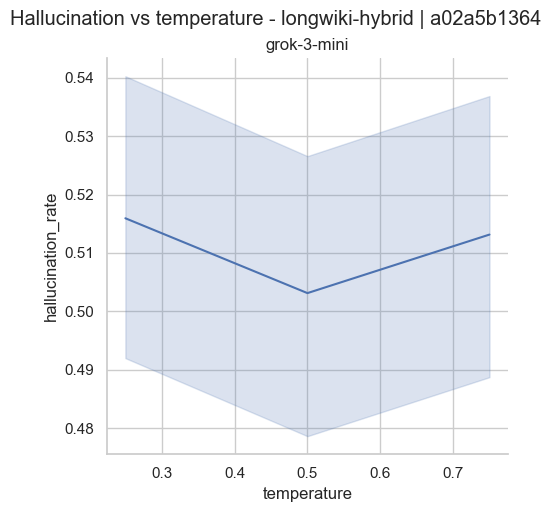

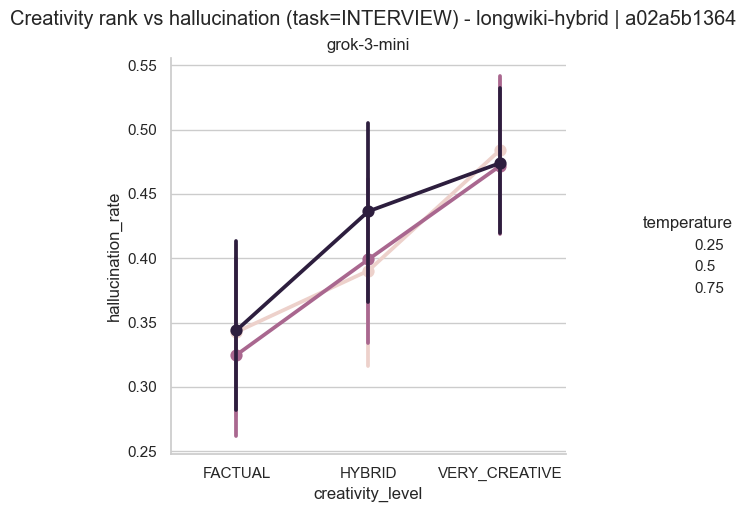

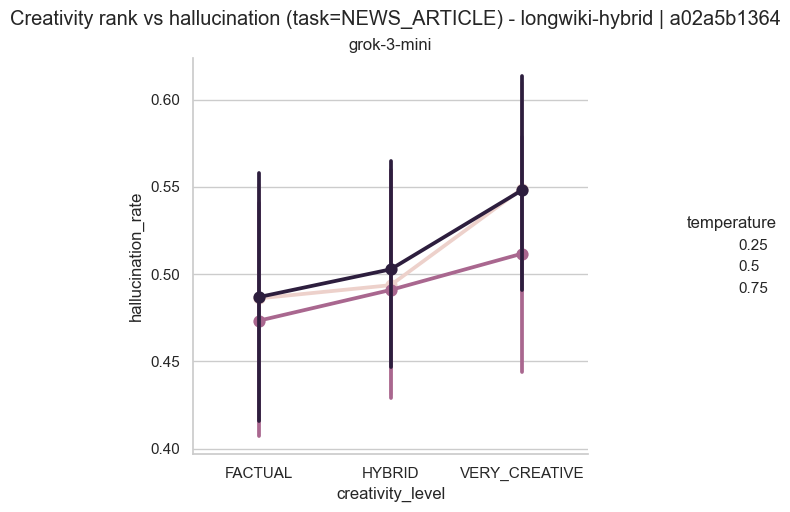

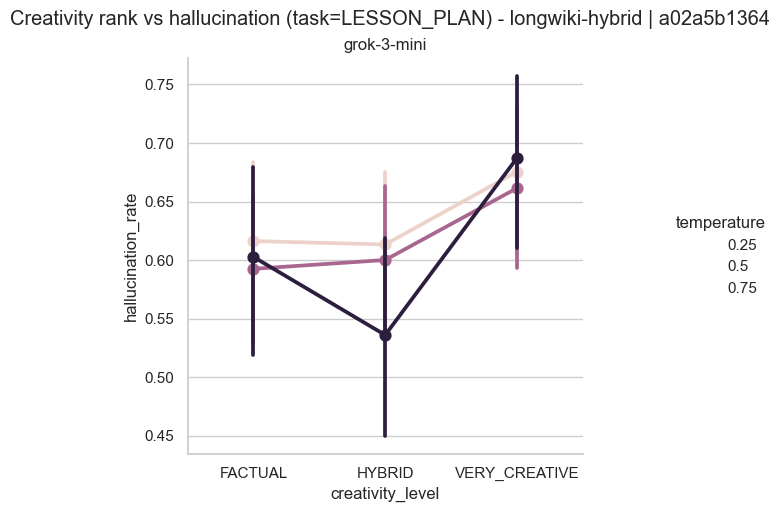

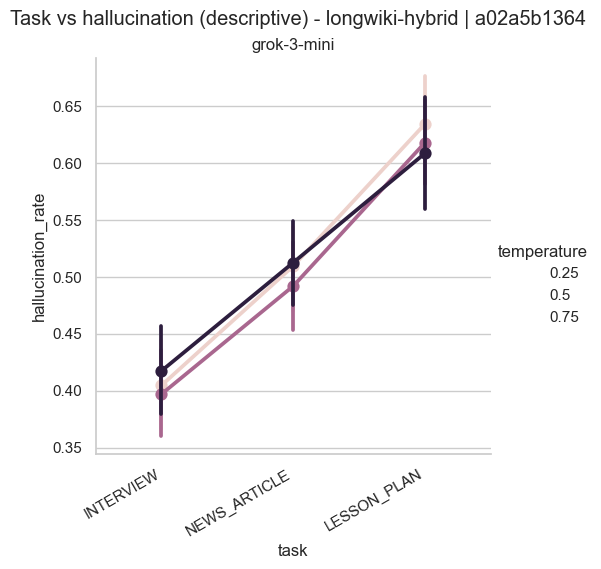

Root: longwiki-hybrid2 | Prompt set: 17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d17dcc8176161ead701 | runs: 7 | prompts: 30


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
19,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.00,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
20,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.25,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
21,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.50,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
22,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.75,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
32,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.25,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
33,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.50,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
34,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.75,300.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,300.0,0.00,1
1,grok-3-mini,300.0,0.25,1
2,grok-3-mini,300.0,0.50,1
3,grok-3-mini,300.0,0.75,1
4,mistral-small-creative,300.0,0.25,1
5,mistral-small-creative,300.0,0.50,1
6,mistral-small-creative,300.0,0.75,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': '17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d17dcc8176161ead701', 'model_name': 'grok-3-mini', 'length_words': 300.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 29, 'mean_diff': 0.010219179034265394, 'median_diff': -0.008241758241758323, 'ci_low': -0.02110186823437481, 'ci_high': 0.042099079087043974}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': '17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d17dcc8176161ead701', 'model_name': 'grok-3-mini', 'length_words': 300.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 29, 'mean_diff': 0.025088498473897863, 'median_diff': 0.031300813008130146, 'ci_low': -0.017820542680915603, 'ci_high': 0.06891105013622544}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': '17fa939f3ed1dae86a765d163e29c0ff0c3599f3098a8d17dcc8176161ead701', 'model_name': 

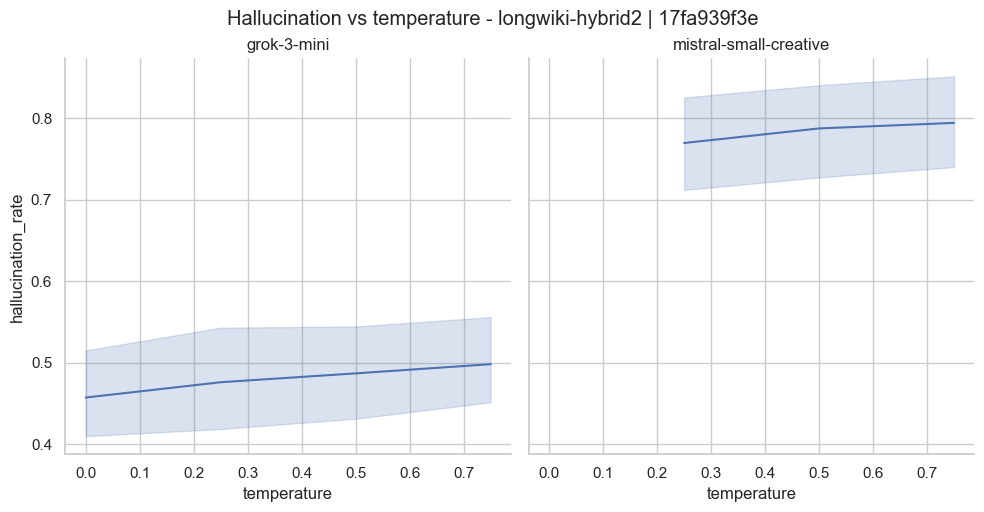

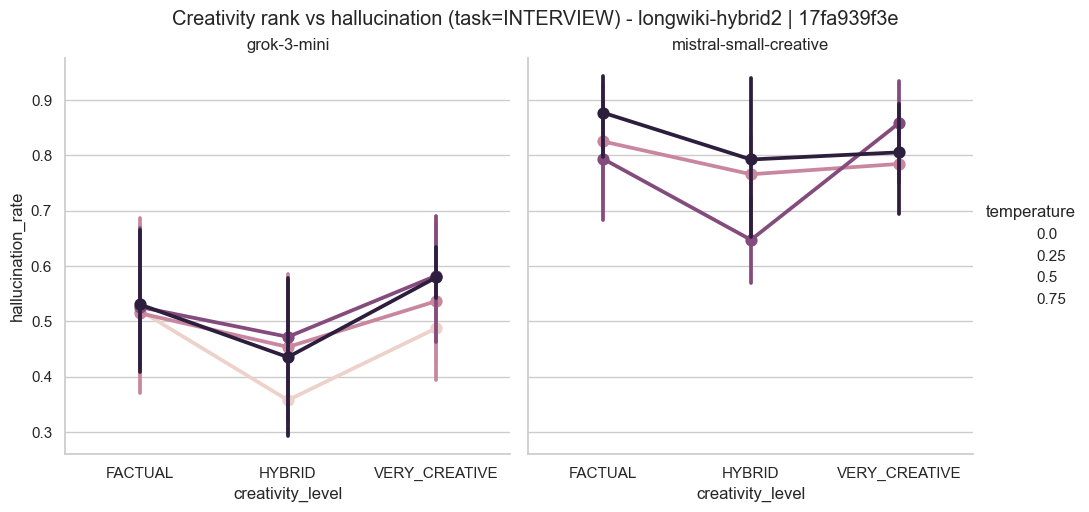

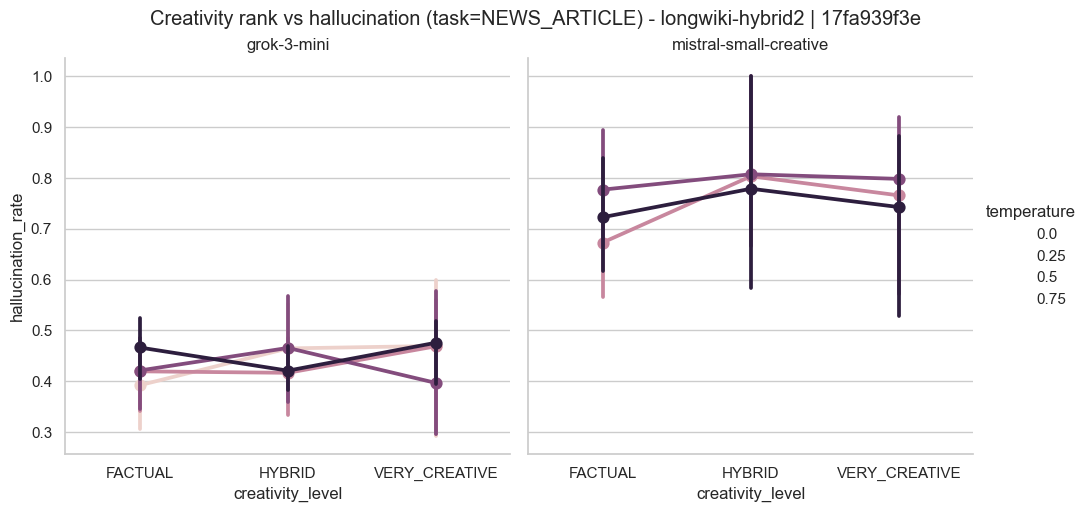

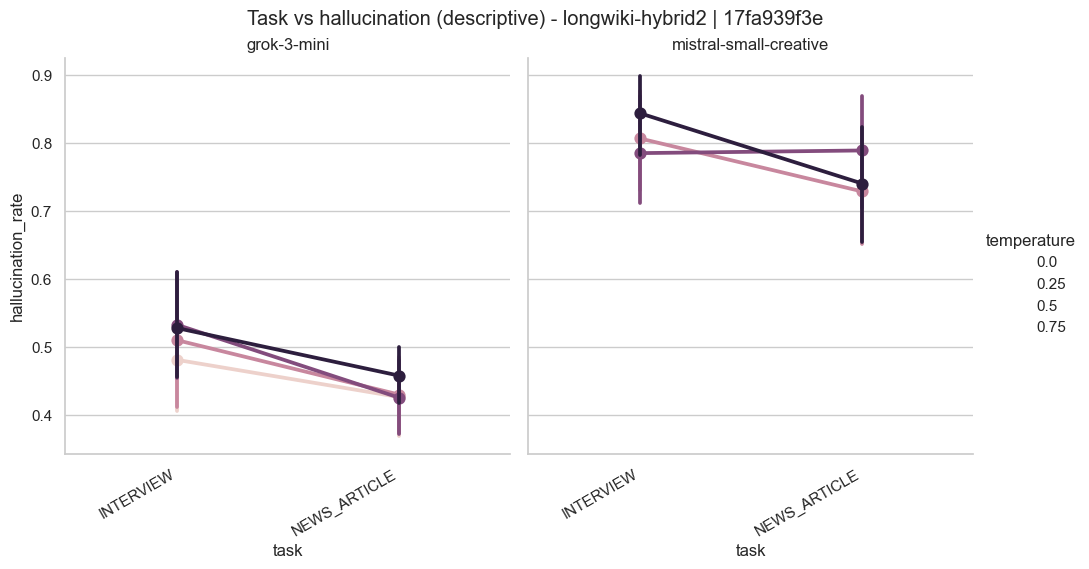

Root: longwiki-hybrid2 | Prompt set: cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57ba2c9330938430f3ff | runs: 12 | prompts: 30


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
11,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
12,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
13,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
14,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
23,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
24,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
25,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
26,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
35,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
36,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,gemini-3-flash-preview,50.0,0.00,1
1,gemini-3-flash-preview,50.0,0.25,1
2,gemini-3-flash-preview,50.0,0.50,1
3,gemini-3-flash-preview,50.0,0.75,1
4,grok-3-mini,50.0,0.00,1
5,grok-3-mini,50.0,0.25,1
6,grok-3-mini,50.0,0.50,1
7,grok-3-mini,50.0,0.75,1
8,mistral-small-creative,50.0,0.00,1
9,mistral-small-creative,50.0,0.25,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57ba2c9330938430f3ff', 'model_name': 'gemini-3-flash-preview', 'length_words': 50.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 30, 'mean_diff': 0.03875574750332225, 'median_diff': 0.032925407925407935, 'ci_low': -0.02524455732347523, 'ci_high': 0.10092372161712346}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57ba2c9330938430f3ff', 'model_name': 'gemini-3-flash-preview', 'length_words': 50.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 30, 'mean_diff': 0.03284139292653226, 'median_diff': 0.04551282051282052, 'ci_low': -0.01878800925811373, 'ci_high': 0.08275764709791414}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'cb382e6150faef64b432d0e2b5e2eb017d64bd242ffe57ba2c9330938430f3ff', 

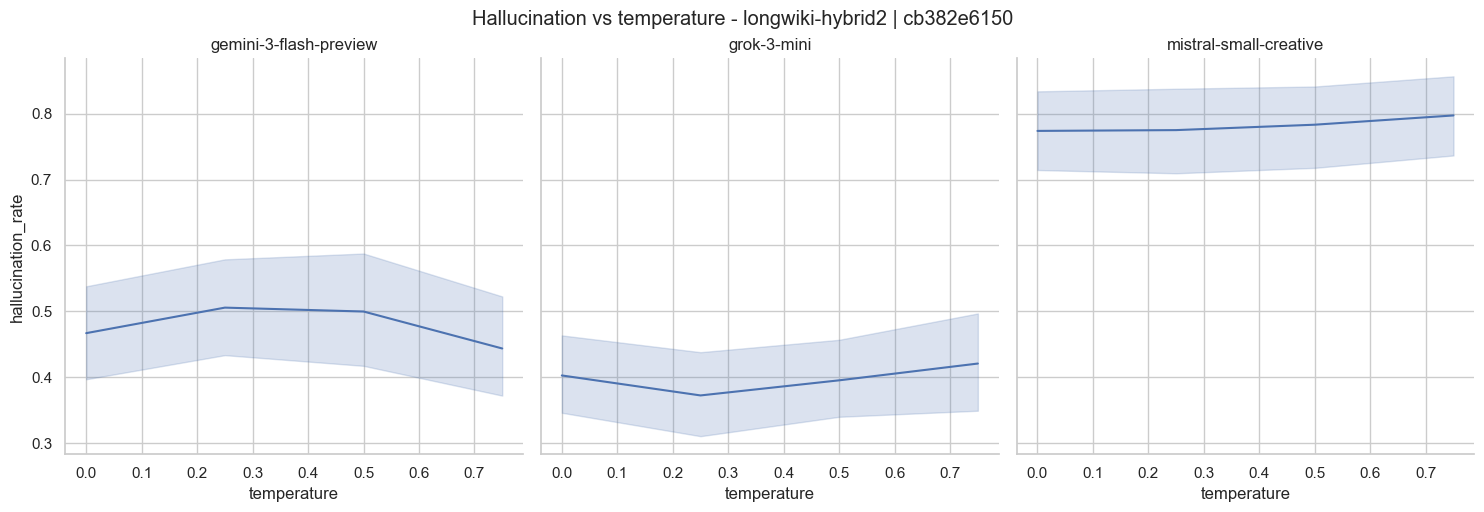

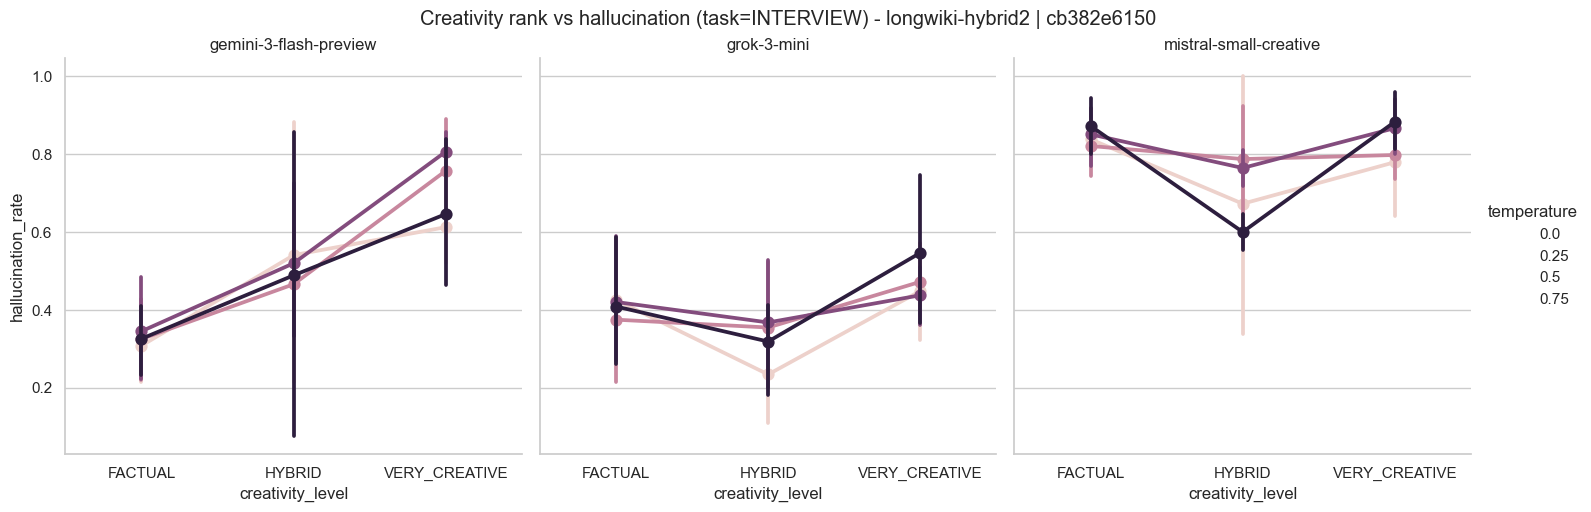

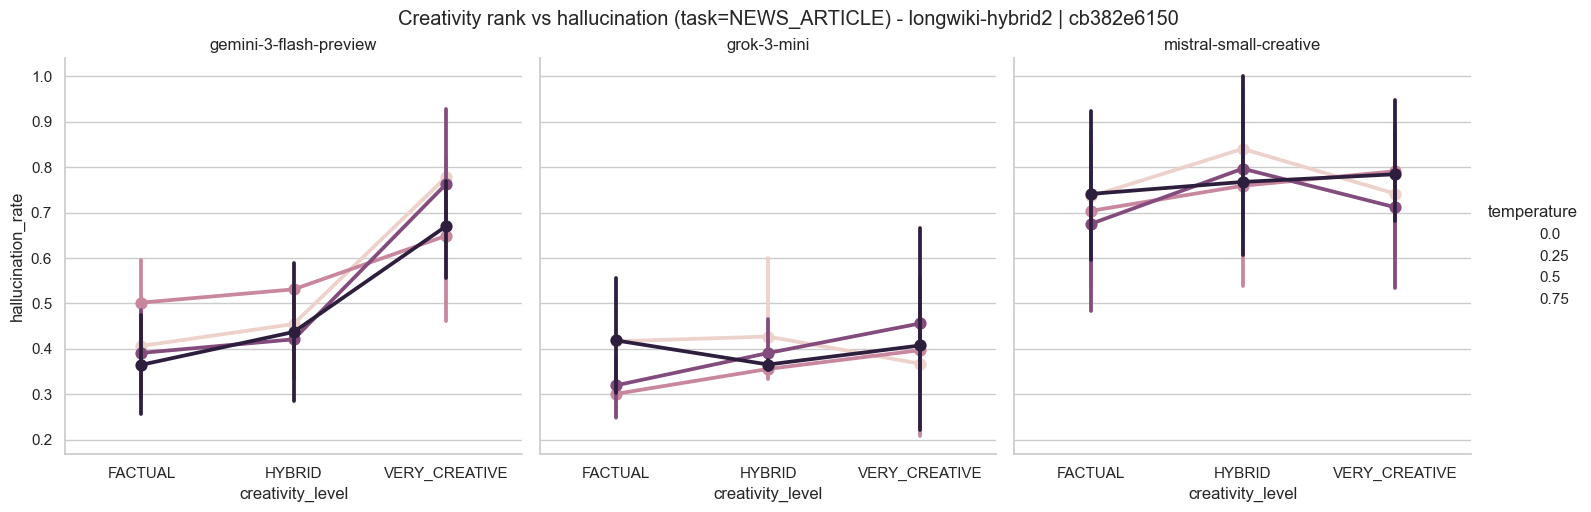

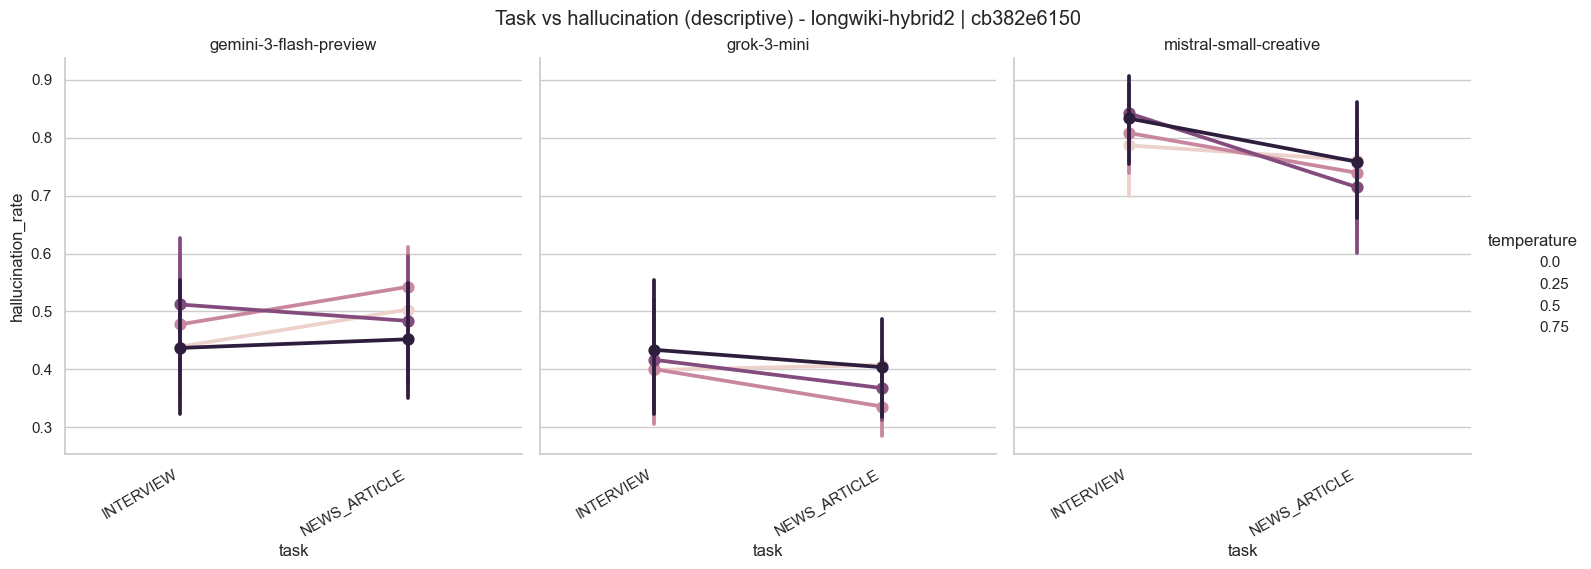

Root: longwiki-hybrid2 | Prompt set: d8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a89eceaa835f603dd71 | runs: 11 | prompts: 30


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
6,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
7,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
8,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
9,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.75,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
15,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
16,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
17,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
18,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.75,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
27,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
28,longwiki-hybrid2/mistral-small-creative__stati...,mistral-small-creative,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,gemini-3-flash-preview,150.0,0.00,1
1,gemini-3-flash-preview,150.0,0.25,1
2,gemini-3-flash-preview,150.0,0.50,1
3,gemini-3-flash-preview,150.0,0.75,1
4,grok-3-mini,150.0,0.00,1
5,grok-3-mini,150.0,0.25,1
6,grok-3-mini,150.0,0.50,1
7,grok-3-mini,150.0,0.75,1
8,mistral-small-creative,150.0,0.00,1
9,mistral-small-creative,150.0,0.25,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'd8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a89eceaa835f603dd71', 'model_name': 'gemini-3-flash-preview', 'length_words': 150.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 30, 'mean_diff': 0.017639736495454007, 'median_diff': -0.01971326164874554, 'ci_low': -0.028795081127351612, 'ci_high': 0.0628576486443581}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'd8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a89eceaa835f603dd71', 'model_name': 'gemini-3-flash-preview', 'length_words': 150.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 30, 'mean_diff': 0.008615964509711674, 'median_diff': 0.0036630036630035945, 'ci_low': -0.031854871483204907, 'ci_high': 0.04984358352823418}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid2', 'prompt_set_id': 'd8160d5cfb0f66dd3aee9f6cfca02bcefd00b69d92920a89eceaa835f603

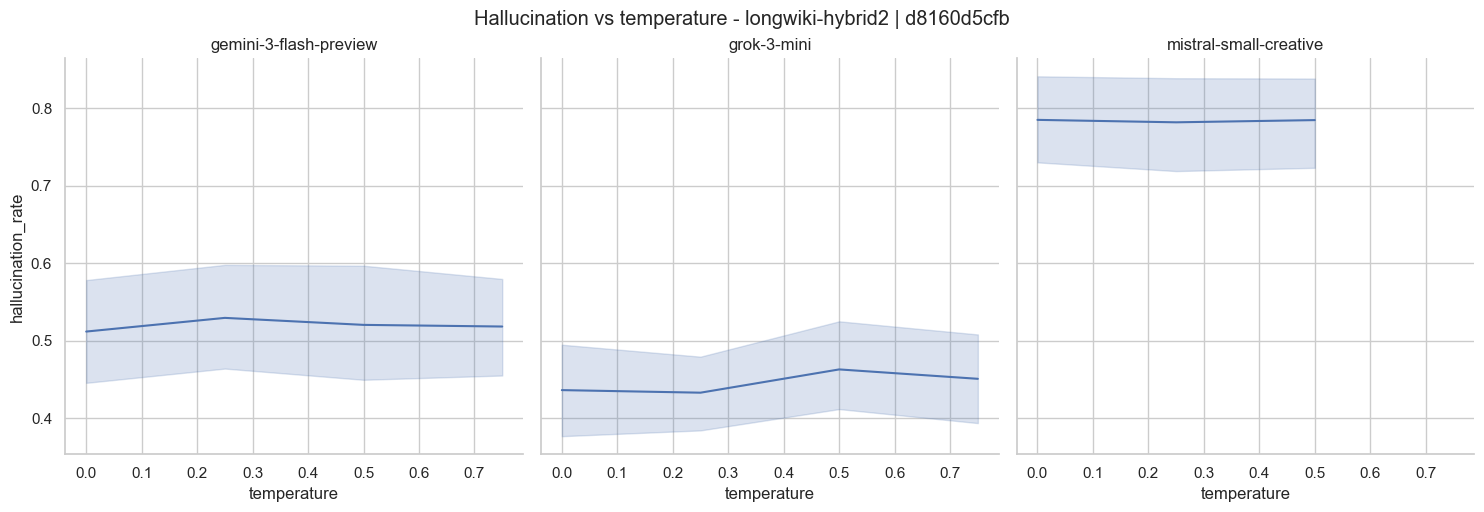

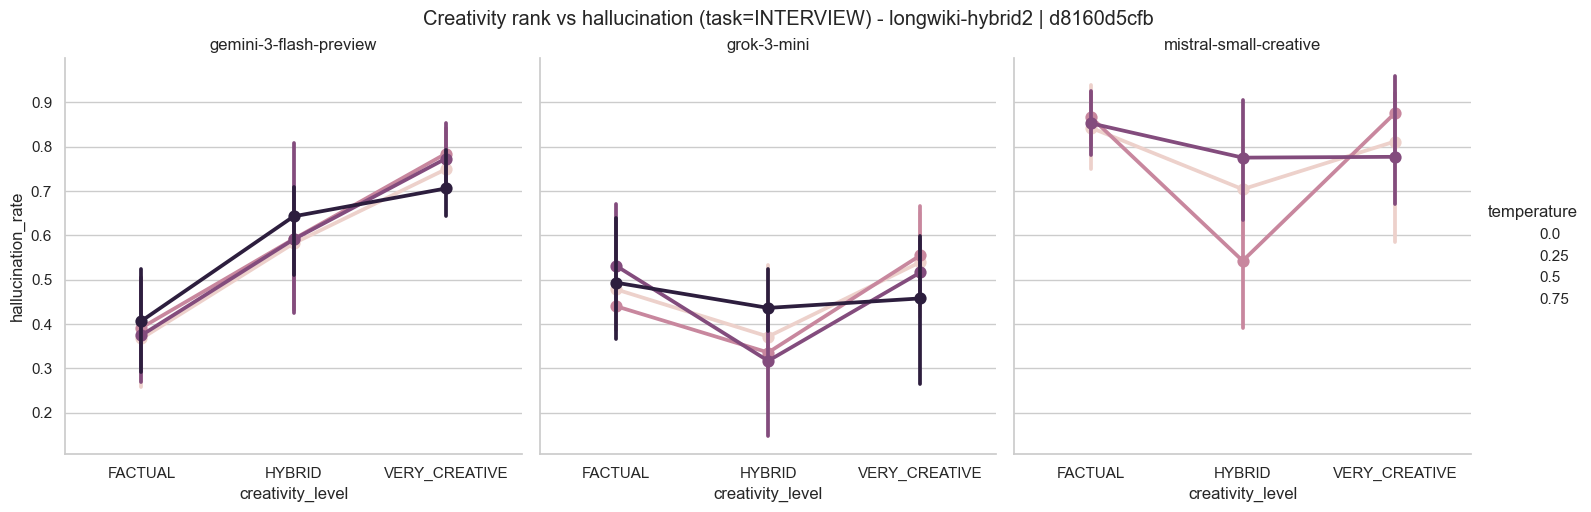

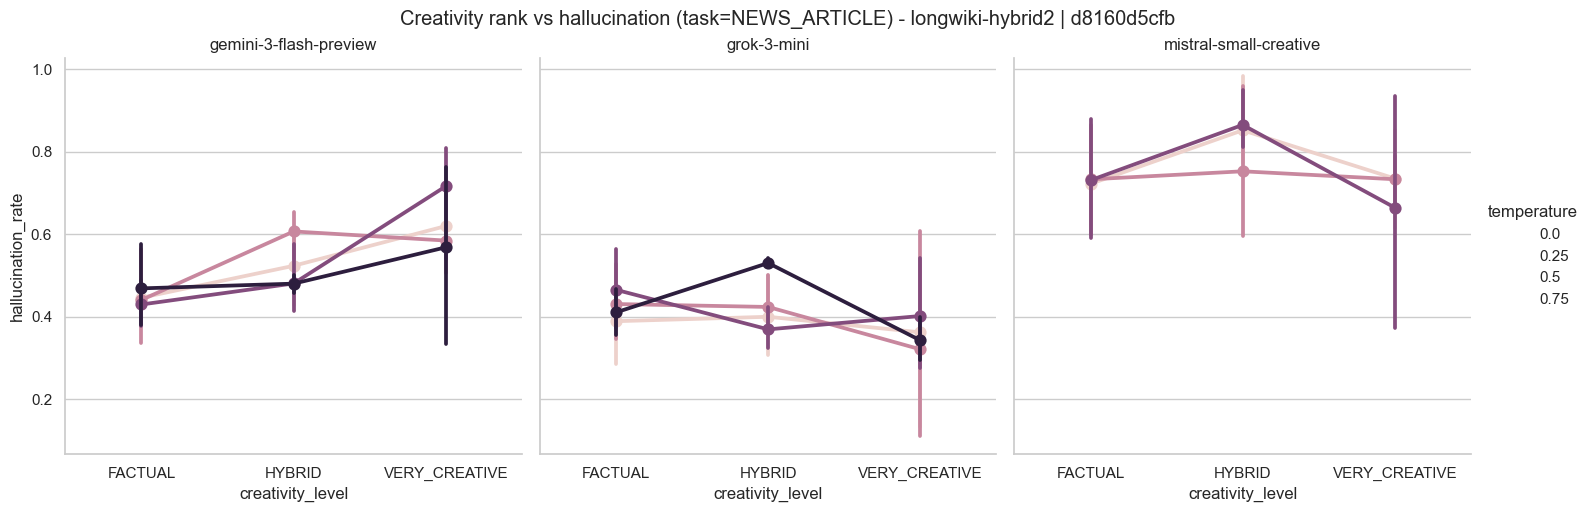

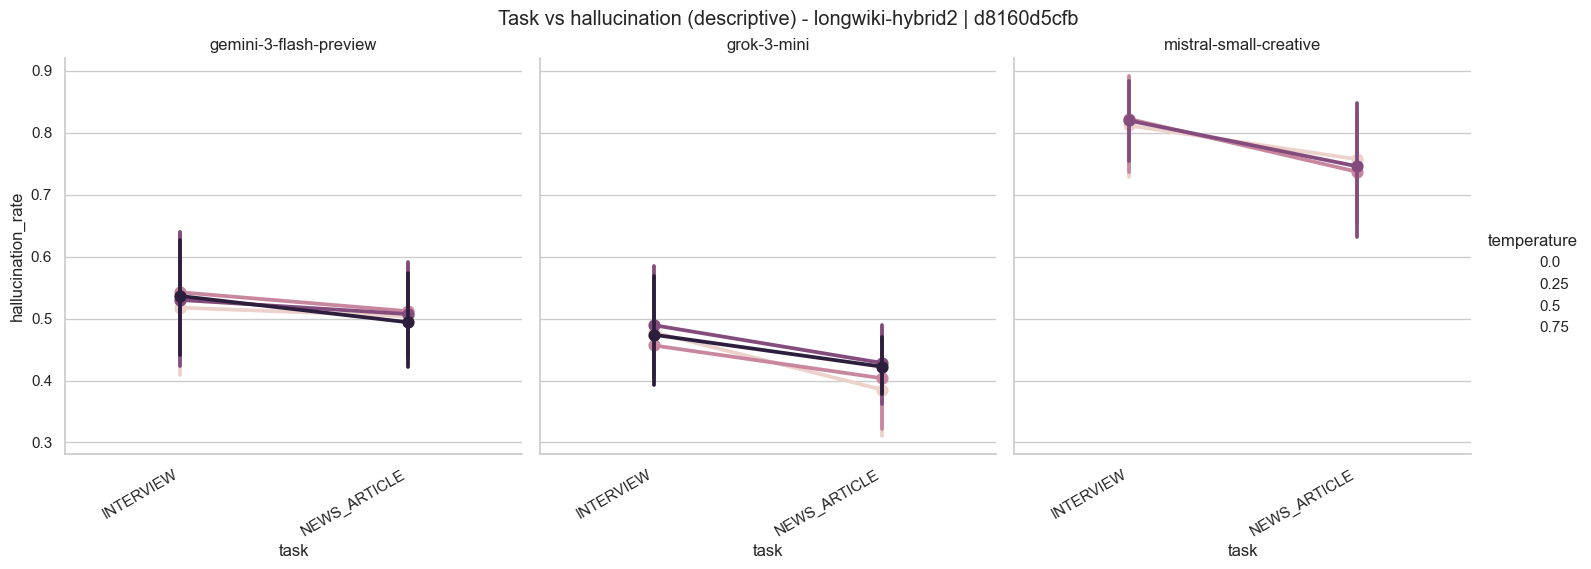

Root: longwiki-hybrid300 | Prompt set: 22013e7733baae0399004b01e3a2c400940f008795831deaa0ee3247013d754b | runs: 4 | prompts: 300


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
48,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
49,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
50,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
51,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,50.0,0.00,1
1,grok-3-mini,50.0,0.25,1
2,grok-3-mini,50.0,0.50,1
3,grok-3-mini,50.0,0.75,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '22013e7733baae0399004b01e3a2c400940f008795831deaa0ee3247013d754b', 'model_name': 'grok-3-mini', 'length_words': 50.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 294, 'mean_diff': -0.0029353807763900465, 'median_diff': 0.0, 'ci_low': -0.018454783222726392, 'ci_high': 0.012231740806911438}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '22013e7733baae0399004b01e3a2c400940f008795831deaa0ee3247013d754b', 'model_name': 'grok-3-mini', 'length_words': 50.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 296, 'mean_diff': -0.0031203432433183306, 'median_diff': 0.0021008403361344463, 'ci_low': -0.020156712180451678, 'ci_high': 0.013648587669895922}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '22013e7733baae0399004b01e3a2c400940f008795831deaa0ee3247013d754b', 'model_name': 'grok

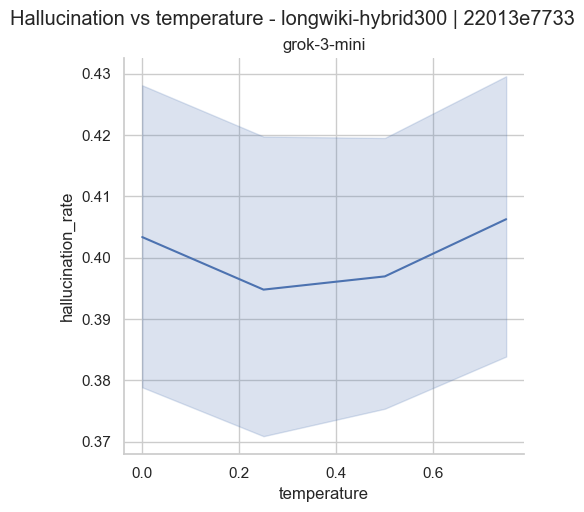

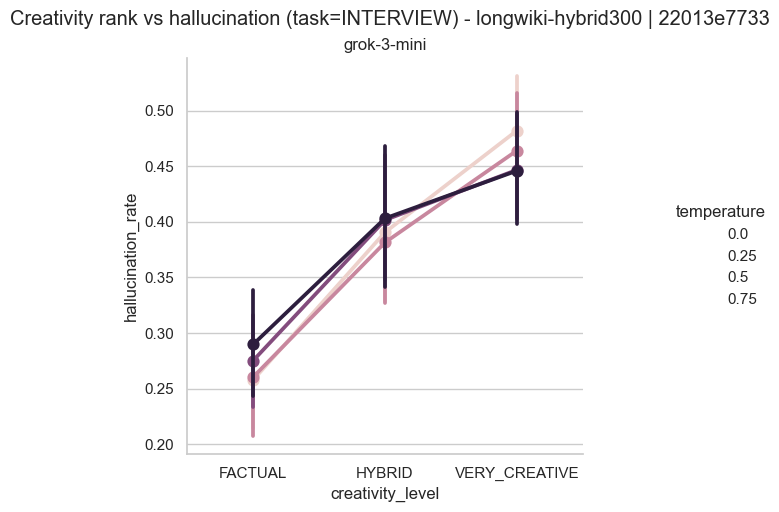

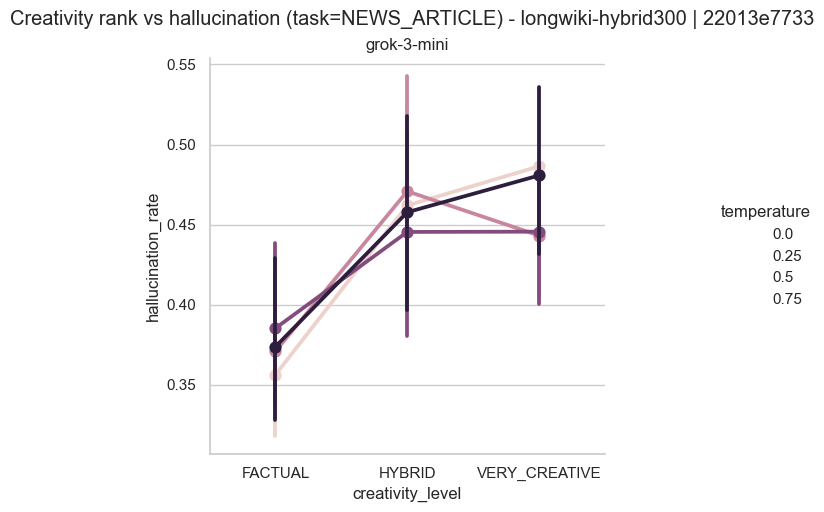

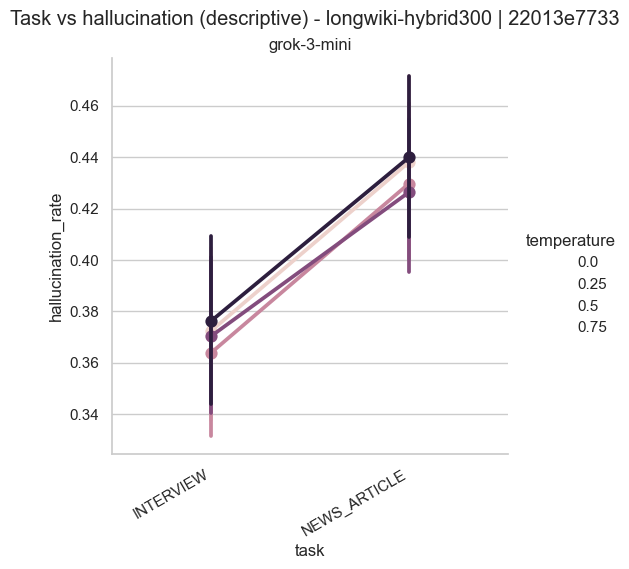

Root: longwiki-hybrid300 | Prompt set: 36572e6c238cef6c4cbc47046886a56c7ee664b31dc0a796c80e1be6bfc98e36 | runs: 3 | prompts: 299


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
40,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
41,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
42,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,150.0,0.00,1
1,grok-3-mini,150.0,0.25,1
2,grok-3-mini,150.0,0.50,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '36572e6c238cef6c4cbc47046886a56c7ee664b31dc0a796c80e1be6bfc98e36', 'model_name': 'grok-3-mini', 'length_words': 150.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 295, 'mean_diff': -0.005413813799616212, 'median_diff': 0.0, 'ci_low': -0.020482277871863047, 'ci_high': 0.010062258906065224}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '36572e6c238cef6c4cbc47046886a56c7ee664b31dc0a796c80e1be6bfc98e36', 'model_name': 'grok-3-mini', 'length_words': 150.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 292, 'mean_diff': -0.012588586815356465, 'median_diff': -0.018395414047587988, 'ci_low': -0.027390970389587103, 'ci_high': 0.0015544344987294659}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '36572e6c238cef6c4cbc47046886a56c7ee664b31dc0a796c80e1be6bfc98e36', 'model_name': 'gro

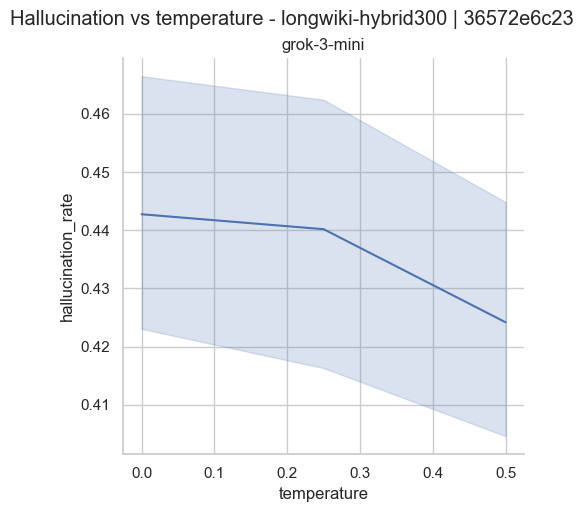

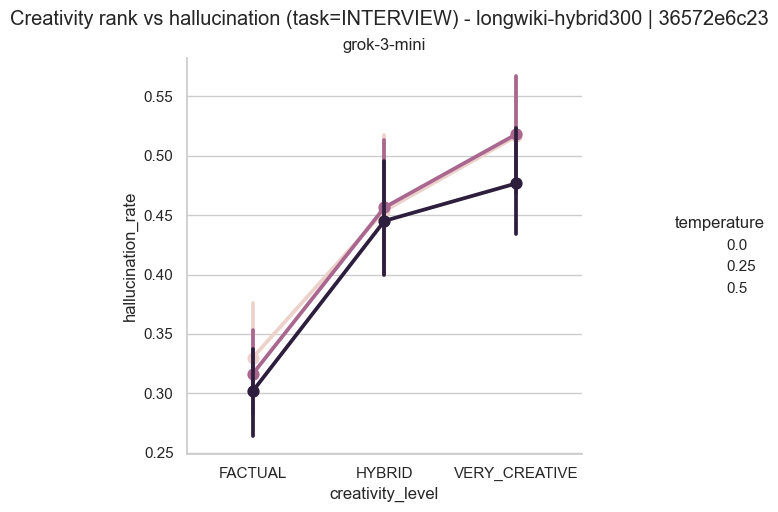

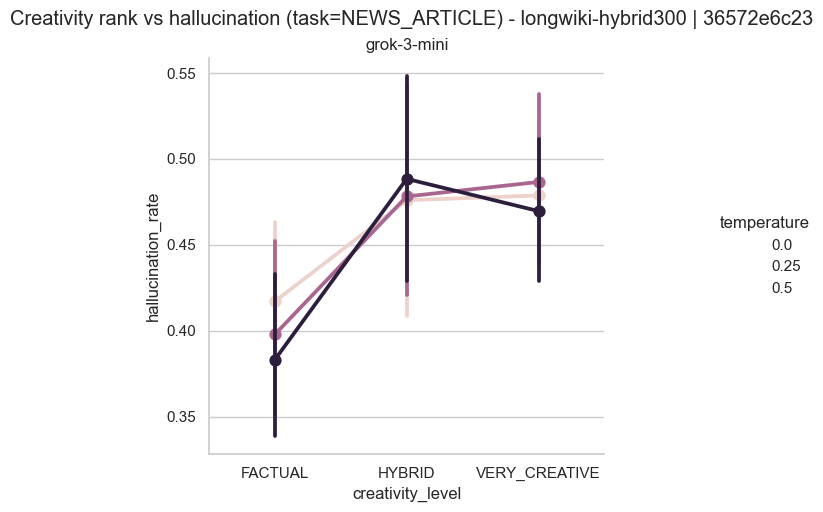

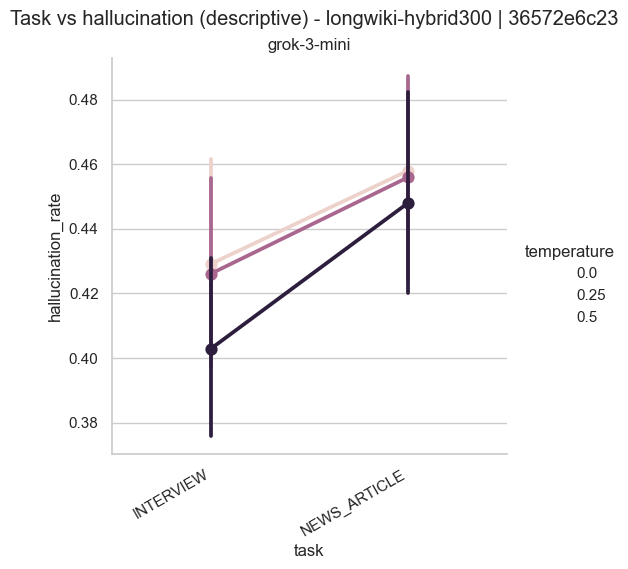

Root: longwiki-hybrid300 | Prompt set: 644d5c465960faa35f1652f402ca824ed0878ec3ff6667b4c47eb00cfcf8dde5 | runs: 4 | prompts: 300


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
44,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
45,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
46,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
47,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.75,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,300.0,0.00,1
1,grok-3-mini,300.0,0.25,1
2,grok-3-mini,300.0,0.50,1
3,grok-3-mini,300.0,0.75,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '644d5c465960faa35f1652f402ca824ed0878ec3ff6667b4c47eb00cfcf8dde5', 'model_name': 'grok-3-mini', 'length_words': 300.0, 'temperature_a': 0.0, 'temperature_b': 0.25, 'n_paired': 294, 'mean_diff': 0.0016454192078647777, 'median_diff': 0.009657027853205602, 'ci_low': -0.011689696411759671, 'ci_high': 0.014660466629796056}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '644d5c465960faa35f1652f402ca824ed0878ec3ff6667b4c47eb00cfcf8dde5', 'model_name': 'grok-3-mini', 'length_words': 300.0, 'temperature_a': 0.0, 'temperature_b': 0.5, 'n_paired': 292, 'mean_diff': 0.013134520311119068, 'median_diff': 0.01772359584859584, 'ci_low': -0.00020616064002893699, 'ci_high': 0.026362363375477038}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid300', 'prompt_set_id': '644d5c465960faa35f1652f402ca824ed0878ec3ff6667b4c47eb00cfcf8dde5', 'mo

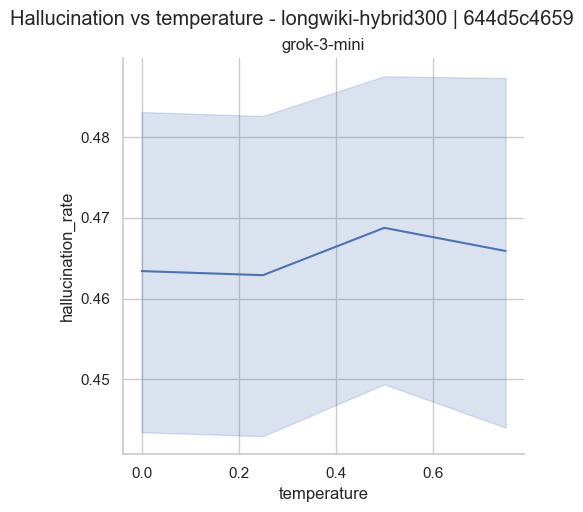

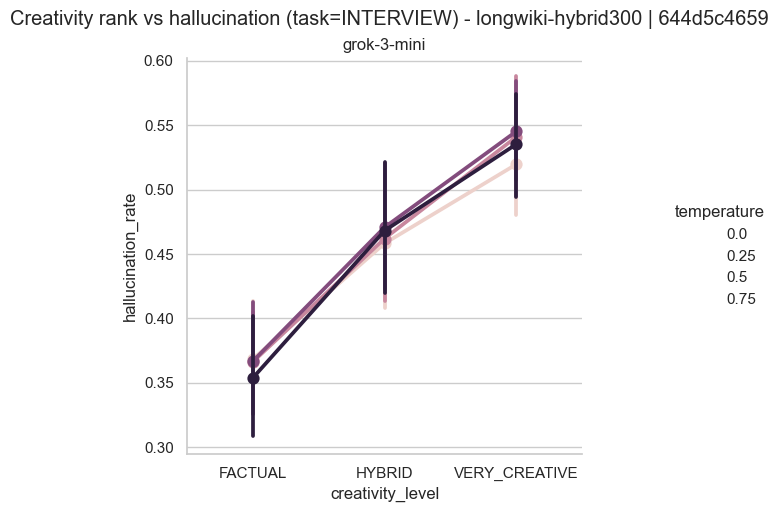

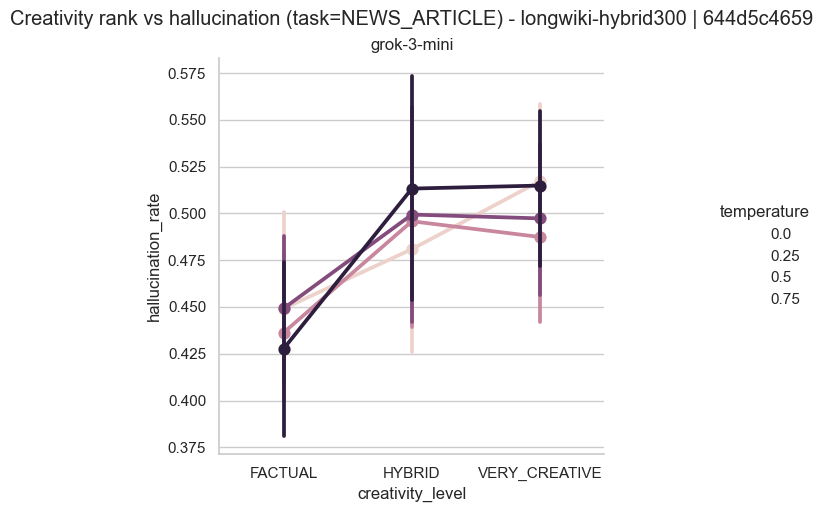

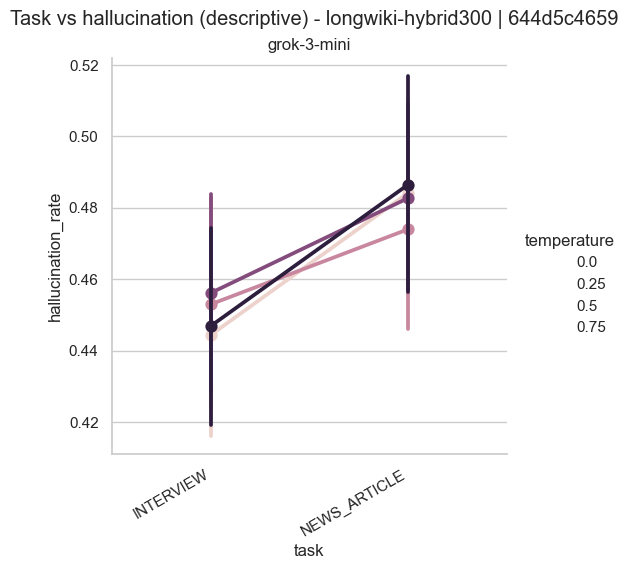

In [44]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip analysis A.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    CREATIVITY_ORDER = ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']

    group_keys = (
        df_metrics[['root', 'prompt_set_id']]
        .dropna()
        .drop_duplicates()
        .sort_values(['root', 'prompt_set_id'])
        .itertuples(index=False, name=None)
    )

    for root, prompt_set_id in group_keys:
        root_name = Path(str(root)).name
        df_group = df_metrics[(df_metrics['root'] == root) & (df_metrics['prompt_set_id'] == prompt_set_id)]
        df_runs_group = df_runs_filtered[(df_runs_filtered['root'] == root) & (df_runs_filtered['prompt_set_id'] == prompt_set_id)]

        if df_group.empty:
            continue

        group_label = f"{root_name} | {prompt_set_id[:10]}"

        print('' + '=' * 120)
        print(
            f"Root: {root_name} | Prompt set: {prompt_set_id} | "
            f"runs: {df_runs_group['run_id'].nunique()} | prompts: {df_group['prompt_id'].nunique()}"
        )

        # Run summary
        display(
            df_runs_group[[
                'run_id', 'model_name', 'temperature', 'length_words', 'tasks',
                'n_prompts', 'has_output_csv', 'has_generation'
            ]].sort_values(['model_name', 'length_words', 'temperature', 'run_id'])
        )

        # Availability grid
        grid = availability_grid(df_runs_group)
        if not grid.empty:
            print('Availability grid (model x length x temperature):')
            display(grid.sort_values(['model_name', 'length_words', 'temperature']))

        # Collapse replicate runs: one row per (condition, prompt_id)
        df_prompt_unit = (
            df_group
            .groupby(['model_name', 'temperature', 'length_words', 'prompt_id'], as_index=False)
            .agg(
                hallucination_rate=('hallucination_rate', 'mean'),
                task=('task', 'first'),
                creativity_level=('creativity_level', 'first'),
            )
        )

        # Ordered categories for readability
        if df_prompt_unit['creativity_level'].notna().any():
            present = df_prompt_unit['creativity_level'].dropna().unique().tolist()
            if set(present).issubset(set(CREATIVITY_ORDER)):
                df_prompt_unit['creativity_level'] = pd.Categorical(
                    df_prompt_unit['creativity_level'],
                    categories=CREATIVITY_ORDER,
                    ordered=True,
                )

        # Condition-level prompt means for paired comparisons
        cond_cols = ['model_name', 'temperature', 'length_words']
        df_cond = condition_prompt_means(df_group, cond_cols, id_col='prompt_id')

        # Temperature effect within model & length
        print('Temperature effect (paired by prompt_id):')
        for (model_name, length_words), sub in df_cond.groupby(['model_name', 'length_words']):
            temps = sorted([t for t in sub['temperature'].dropna().unique()])
            if len(temps) < 2:
                continue
            for t_a, t_b in itertools.combinations(temps, 2):
                df_a = sub[sub['temperature'] == t_a]
                df_b = sub[sub['temperature'] == t_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='prompt_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'temperature',
                    'root': root_name,
                    'prompt_set_id': prompt_set_id,
                    'model_name': model_name,
                    'length_words': length_words,
                    'temperature_a': t_a,
                    'temperature_b': t_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Model effect within temperature & length
        print('Model effect (paired by prompt_id):')
        for (temperature, length_words), sub in df_cond.groupby(['temperature', 'length_words']):
            models = sorted([m for m in sub['model_name'].dropna().unique()])
            if len(models) < 2:
                continue
            for m_a, m_b in itertools.combinations(models, 2):
                df_a = sub[sub['model_name'] == m_a]
                df_b = sub[sub['model_name'] == m_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='prompt_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'model',
                    'root': root_name,
                    'prompt_set_id': prompt_set_id,
                    'temperature': temperature,
                    'length_words': length_words,
                    'model_a': m_a,
                    'model_b': m_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Plots
        if HAVE_SNS:
            # 1) Hallucination vs temperature
            g = sns.relplot(
                data=df_prompt_unit,
                x='temperature',
                y='hallucination_rate',
                col='model_name',
                kind='line',
                estimator='mean',
                errorbar=('ci', 95),
                facet_kws={'sharey': True, 'sharex': True},
            )
            g.set_titles(col_template='{col_name}')
            g.fig.suptitle(f"Hallucination vs temperature - {group_label}", y=1.02)
            plt.show()

            # 2) Creativity vs hallucination (descriptive) - one plot per task
            if df_prompt_unit['creativity_level'].notna().any() and df_prompt_unit['task'].notna().any():
                temps = sorted(df_prompt_unit['temperature'].dropna().unique())
                task_list = [t for t in TASKS_FOCUS if t in df_prompt_unit['task'].unique().tolist()]
                other_tasks = [t for t in sorted(df_prompt_unit['task'].dropna().unique()) if t not in task_list]
                task_list = task_list + other_tasks

                for task_name in task_list:
                    df_task = df_prompt_unit[df_prompt_unit['task'] == task_name].dropna(subset=['creativity_level'])
                    if df_task.empty:
                        continue

                    g = sns.catplot(
                        data=df_task,
                        x='creativity_level',
                        y='hallucination_rate',
                        hue='temperature',
                        col='model_name',
                        kind='point',
                        estimator='mean',
                        errorbar=('ci', 95),
                        order=CREATIVITY_ORDER,
                        hue_order=temps,
                        sharey=True,
                    )
                    g.set_titles(col_template='{col_name}')
                    g.fig.suptitle(
                        f"Creativity rank vs hallucination (task={task_name}) - {group_label}",
                        y=1.02,
                    )
                    plt.show()


            # 3) Task vs hallucination (descriptive)
            if df_prompt_unit['task'].notna().any() and df_prompt_unit['task'].nunique() <= 12:
                temps = sorted(df_prompt_unit['temperature'].dropna().unique())
                task_order = [t for t in TASKS_FOCUS if t in df_prompt_unit['task'].unique().tolist()]
                other_tasks = [t for t in sorted(df_prompt_unit['task'].dropna().unique()) if t not in task_order]
                task_order = task_order + other_tasks

                g = sns.catplot(
                    data=df_prompt_unit.dropna(subset=['task']),
                    x='task',
                    y='hallucination_rate',
                    hue='temperature',
                    col='model_name',
                    kind='point',
                    estimator='mean',
                    errorbar=('ci', 95),
                    order=task_order,
                    hue_order=temps,
                    sharey=True,
                )
                g.set_titles(col_template='{col_name}')
                g.set_xticklabels(rotation=30, ha='right')
                g.fig.suptitle(
                    f"Task vs hallucination (descriptive) - {group_label}",
                    y=1.02,
                )
                plt.show()
        else:
            print('Seaborn unavailable - skipping plots.')


## 6) Analyses LENGTH par instance_set_id (instances identiques, prompts differents)


Root: longwiki-hybrid | Instance set: 04f2440b1dc98c6870508408947d1f6d20352afe6ba249b1011d3b82e96c7972 | runs: 3 | instances: 448


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True


Length effect (paired by instance_id):


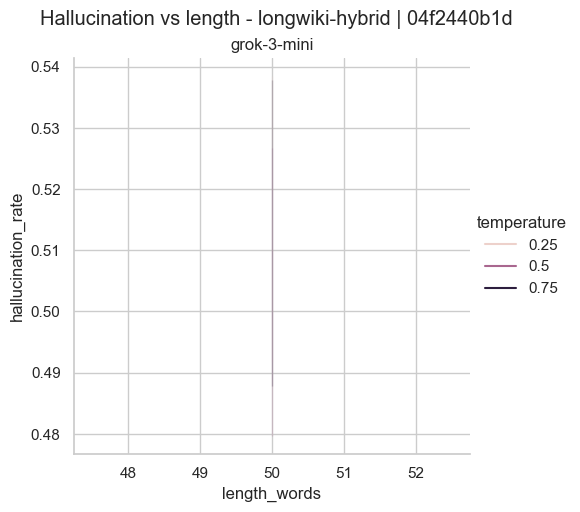

Root: longwiki-hybrid2 | Instance set: 390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a00c23be76c8bb3f45cb | runs: 30 | instances: 30


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
11,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
12,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
13,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
14,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
6,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
7,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
8,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
9,longwiki-hybrid2/gemini-3-flash-preview__stati...,gemini-3-flash-preview,0.75,150.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
23,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True
24,longwiki-hybrid2/grok-3-mini__static_prompts_l...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",30,True,True


Length effect (paired by instance_id):
{'comparison_type': 'length', 'root': 'longwiki-hybrid2', 'instance_set_id': '390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a00c23be76c8bb3f45cb', 'model_name': 'gemini-3-flash-preview', 'temperature': 0.0, 'length_a': 50.0, 'length_b': 150.0, 'n_paired': 30, 'mean_diff': 0.04477459157457174, 'median_diff': 0.08809523809523812, 'ci_low': -0.01659799059379678, 'ci_high': 0.10413262740686646}
{'comparison_type': 'length', 'root': 'longwiki-hybrid2', 'instance_set_id': '390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a00c23be76c8bb3f45cb', 'model_name': 'gemini-3-flash-preview', 'temperature': 0.25, 'length_a': 50.0, 'length_b': 150.0, 'n_paired': 30, 'mean_diff': 0.02365858056670349, 'median_diff': 0.043168301232817285, 'ci_low': -0.034243102023549944, 'ci_high': 0.07439060565125862}
{'comparison_type': 'length', 'root': 'longwiki-hybrid2', 'instance_set_id': '390d7396deb37bfedf50697a6e4e0cbf08cd592c6be5a00c23be76c8bb3f45cb', 'model_name': 'gemini-3-flash

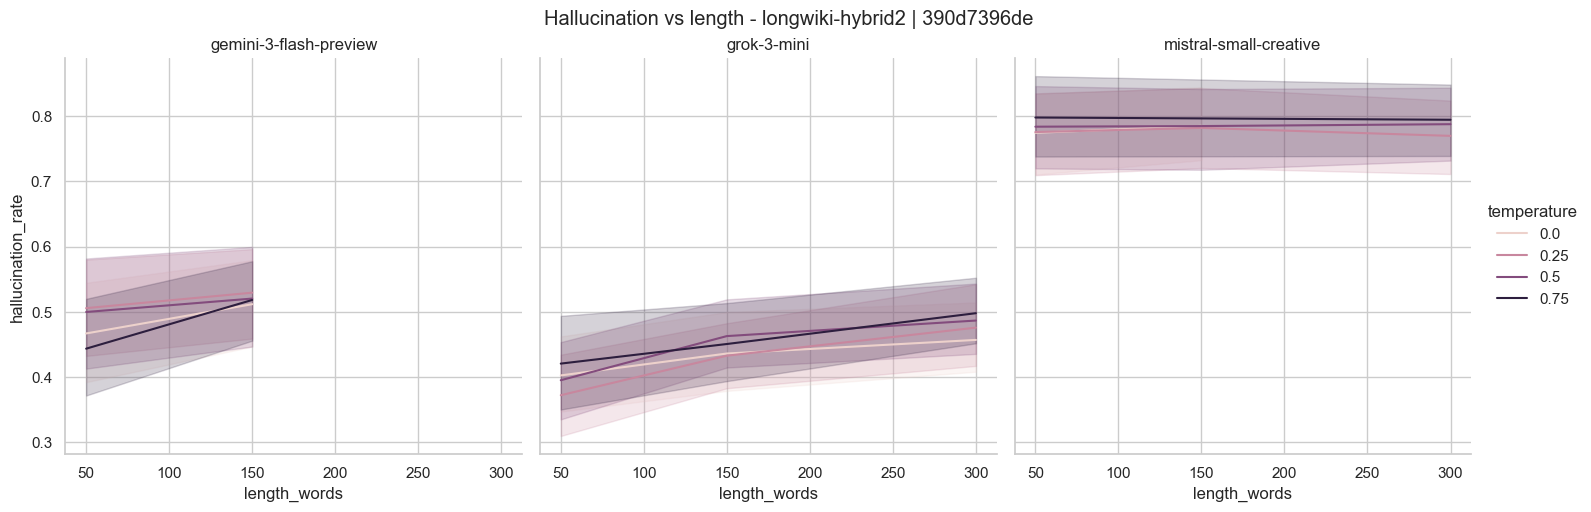

Root: longwiki-hybrid300 | Instance set: 0e0a63a1a3234715c2f5cb6835c9d73887d1fa811bd4fff8408e4361b850c7bc | runs: 11 | instances: 300


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
48,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
49,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
50,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
51,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.75,50.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
40,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
41,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
42,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,150.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
44,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.00,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
45,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.25,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True
46,longwiki-hybrid300/grok-3-mini__static_prompts...,grok-3-mini,0.50,300.0,"[INTERVIEW, NEWS_ARTICLE]",300,True,True


Length effect (paired by instance_id):
{'comparison_type': 'length', 'root': 'longwiki-hybrid300', 'instance_set_id': '0e0a63a1a3234715c2f5cb6835c9d73887d1fa811bd4fff8408e4361b850c7bc', 'model_name': 'grok-3-mini', 'temperature': 0.0, 'length_a': 50.0, 'length_b': 150.0, 'n_paired': 296, 'mean_diff': 0.042918993774850527, 'median_diff': 0.05336438923395448, 'ci_low': 0.027613311596497533, 'ci_high': 0.05913495526674914}
{'comparison_type': 'length', 'root': 'longwiki-hybrid300', 'instance_set_id': '0e0a63a1a3234715c2f5cb6835c9d73887d1fa811bd4fff8408e4361b850c7bc', 'model_name': 'grok-3-mini', 'temperature': 0.0, 'length_a': 50.0, 'length_b': 300.0, 'n_paired': 296, 'mean_diff': 0.06127877554262074, 'median_diff': 0.0625, 'ci_low': 0.04645867212770069, 'ci_high': 0.07544114567310997}
{'comparison_type': 'length', 'root': 'longwiki-hybrid300', 'instance_set_id': '0e0a63a1a3234715c2f5cb6835c9d73887d1fa811bd4fff8408e4361b850c7bc', 'model_name': 'grok-3-mini', 'temperature': 0.0, 'length_a'

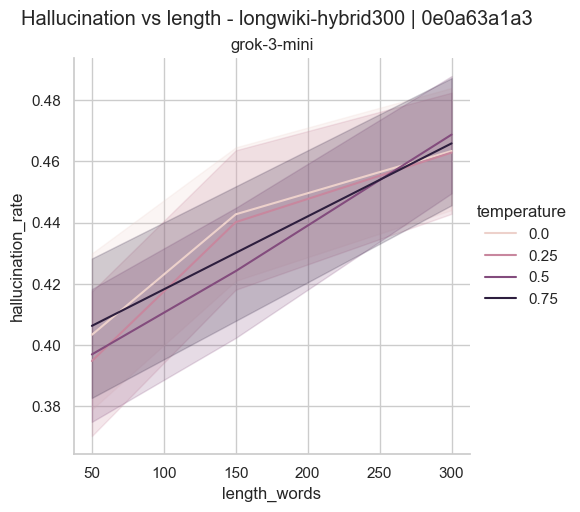

In [45]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip analysis B.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    # Filter out rows with missing instance_id
    df_metrics = df_metrics[df_metrics['instance_id'].notna()]

    group_keys = (
        df_metrics[['root', 'instance_set_id']]
        .dropna()
        .drop_duplicates()
        .sort_values(['root', 'instance_set_id'])
        .itertuples(index=False, name=None)
    )

    for root, instance_set_id in group_keys:
        root_name = Path(str(root)).name
        df_group = df_metrics[(df_metrics['root'] == root) & (df_metrics['instance_set_id'] == instance_set_id)]
        df_runs_group = df_runs_filtered[(df_runs_filtered['root'] == root) & (df_runs_filtered['instance_set_id'] == instance_set_id)]

        if df_group.empty:
            continue

        group_label = f"{root_name} | {instance_set_id[:10]}"

        print('' + '=' * 120)
        print(
            f"Root: {root_name} | Instance set: {instance_set_id} | "
            f"runs: {df_runs_group['run_id'].nunique()} | instances: {df_group['instance_id'].nunique()}"
        )

        display(
            df_runs_group[[
                'run_id', 'model_name', 'temperature', 'length_words', 'tasks',
                'n_prompts', 'has_output_csv', 'has_generation'
            ]].sort_values(['model_name', 'length_words', 'temperature', 'run_id'])
        )

        # Collapse replicate runs: one row per (condition, instance_id)
        df_instance_unit = (
            df_group
            .groupby(['model_name', 'temperature', 'length_words', 'instance_id'], as_index=False)
            .agg(
                hallucination_rate=('hallucination_rate', 'mean'),
                task=('task', 'first'),
                creativity_level=('creativity_level', 'first'),
            )
        )

        # Length effect within model & temperature
        print('Length effect (paired by instance_id):')
        for (model_name, temperature), sub in df_instance_unit.groupby(['model_name', 'temperature']):
            lengths = sorted([l for l in sub['length_words'].dropna().unique()])
            if len(lengths) < 2:
                continue
            for l_a, l_b in itertools.combinations(lengths, 2):
                df_a = sub[sub['length_words'] == l_a]
                df_b = sub[sub['length_words'] == l_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='instance_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'length',
                    'root': root_name,
                    'instance_set_id': instance_set_id,
                    'model_name': model_name,
                    'temperature': temperature,
                    'length_a': l_a,
                    'length_b': l_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Plot
        if HAVE_SNS:
            g = sns.relplot(
                data=df_instance_unit,
                x='length_words',
                y='hallucination_rate',
                col='model_name',
                hue='temperature',
                kind='line',
                estimator='mean',
                errorbar=('ci', 95),
                facet_kws={'sharey': True, 'sharex': True},
            )
            g.set_titles(col_template='{col_name}')
            g.fig.suptitle(f"Hallucination vs length - {group_label}", y=1.02)
            plt.show()
        else:
            print('Seaborn unavailable - skipping plots.')


In [46]:
# ---- Plotly: distributions interactives ----
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, HTML

# Base pour plots
df_plot = df_prompts[df_prompts['metrics_available']].copy()

# Normaliser pour affichage (categories)
df_plot['length_words_str'] = df_plot['length_words'].astype('Int64').astype(str)
df_plot['temperature_str'] = df_plot['temperature'].astype(str)
df_plot['creativity_rank'] = df_plot['creativity_level'].map({'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2})

# Helpers pour ordre numerique

def fmt_len(v):
    try:
        fv = float(v)
        if fv.is_integer():
            return str(int(fv))
        return str(fv)
    except Exception:
        return str(v)

# Listes de filtres
models = ['ALL'] + sorted(df_plot['model_name'].dropna().unique().tolist())
tasks = ['ALL'] + sorted(df_plot['task'].dropna().unique().tolist())
temps = ['ALL'] + [str(v) for v in sorted(df_plot['temperature'].dropna().unique())]
lengths = ['ALL'] + [fmt_len(v) for v in sorted(df_plot['length_words'].dropna().unique())]
crea = ['ALL'] + ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']

# Parametre X a analyser
x_param_options = {
    'Length words': 'length_words_str',
    'Temperature': 'temperature_str',
    'Creativity rank': 'creativity_level',
    'Task': 'task',
}

# Widgets
w_model = widgets.Dropdown(options=models, value='ALL', description='Model:')
w_task = widgets.Dropdown(options=tasks, value='ALL', description='Task:')
w_temp = widgets.Dropdown(options=temps, value='ALL', description='Temp:')
w_len = widgets.Dropdown(options=lengths, value='ALL', description='Length:')
w_crea = widgets.Dropdown(options=crea, value='ALL', description='Creativity:')
w_xparam = widgets.Dropdown(options=list(x_param_options.keys()), value='Creativity rank', description='X:')


def filter_df(df, model, task, temp, length, creativity):
    d = df.copy()
    if model != 'ALL':
        d = d[d['model_name'] == model]
    if task != 'ALL':
        d = d[d['task'] == task]
    if temp != 'ALL':
        d = d[d['temperature_str'] == temp]
    if length != 'ALL':
        d = d[d['length_words_str'] == length]
    if creativity != 'ALL':
        d = d[d['creativity_level'] == creativity]
    return d


def make_plot(model, task, temp, length, creativity, x_param_label):
    d = filter_df(df_plot, model, task, temp, length, creativity)
    if d.empty:
        print('Aucune donnee pour ces filtres.')
        return

    x_col = x_param_options[x_param_label]

    # Ordres categorie (length toujours croissante)
    temp_order = [str(v) for v in sorted(d['temperature'].dropna().unique())]
    length_order = [fmt_len(v) for v in sorted(d['length_words'].dropna().unique())]

    # Violin plot (distribution + box + points)
    fig = px.violin(
        d,
        x=x_col,
        y='hallucination_rate',
        color='temperature_str',
        box=True,
        points='all',
        hover_data=['model_name', 'task', 'length_words', 'temperature', 'creativity_level', 'title'],
        facet_col=None if model != 'ALL' else 'model_name',
        category_orders={
            'creativity_level': ['FACTUAL', 'HYBRID', 'VERY_CREATIVE'],
            'temperature_str': temp_order,
            'length_words_str': length_order,
        }
    )
    fig.update_layout(
        title=f"Distribution hallucination_rate vs {x_param_label}",
        xaxis_title=x_param_label,
        yaxis_title='Hallucination rate',
        violinmode='group',
        height=450
    )
    fig.show()

    # Afficher le nombre de prompts sous le graphique (apres filtres)
    n_prompts = d['title'].dropna().nunique()
    display(HTML(f"<div style='margin-top:8px'><b>Prompts:</b> {n_prompts}</div>"))


ui = widgets.VBox([
    widgets.HBox([w_model, w_task]),
    widgets.HBox([w_temp, w_len, w_crea]),
    w_xparam
])

out = widgets.interactive_output(
    make_plot,
    {
        'model': w_model,
        'task': w_task,
        'temp': w_temp,
        'length': w_len,
        'creativity': w_crea,
        'x_param_label': w_xparam
    }
)

display(ui, out)


Output()

## 7) Creativite & Tache - detecter si le design permet une analyse appariee


In [47]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip creativity/task analysis.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    def can_within_title_creativity(df):
        required = ['title', 'task', 'length_words', 'model_name', 'temperature', 'creativity_level']
        if not all(c in df.columns for c in required):
            return False
        return df.groupby(['title', 'task', 'length_words', 'model_name', 'temperature'])['creativity_level'].nunique().max() > 1

    def can_within_title_task(df):
        required = ['title', 'creativity_level', 'length_words', 'model_name', 'temperature', 'task']
        if not all(c in df.columns for c in required):
            return False
        return df.groupby(['title', 'creativity_level', 'length_words', 'model_name', 'temperature'])['task'].nunique().max() > 1

    def paired_factor_effect(df, factor_col, match_cols):
        results = []
        for _, sub in df.groupby(match_cols):
            levels = sorted(sub[factor_col].dropna().unique())
            if len(levels) < 2:
                continue
            # average per level within this match group
            level_means = sub.groupby(factor_col)['hallucination_rate'].mean().to_dict()
            for a, b in itertools.combinations(levels, 2):
                if a in level_means and b in level_means:
                    results.append(level_means[b] - level_means[a])
        return np.asarray(results, dtype=float)

    # Creativity
    if can_within_title_creativity(df_metrics):
        diffs = paired_factor_effect(
            df_metrics,
            factor_col='creativity_level',
            match_cols=['title', 'task', 'length_words', 'model_name', 'temperature'],
        )
        stats = summarize_diffs(diffs)
        print('Creativity paired effect (within-title):')
        print(stats)
    else:
        print('Creativity analysis: design does NOT support within-title pairing. Showing descriptive stats only (confounded by topics).')
        display(
            df_metrics.groupby(['model_name', 'creativity_level'])['hallucination_rate']
            .mean()
            .reset_index()
            .sort_values(['model_name', 'hallucination_rate'])
        )

    # Task
    if can_within_title_task(df_metrics):
        diffs = paired_factor_effect(
            df_metrics,
            factor_col='task',
            match_cols=['title', 'creativity_level', 'length_words', 'model_name', 'temperature'],
        )
        stats = summarize_diffs(diffs)
        print('Task paired effect (within-title):')
        print(stats)
    else:
        print('Task analysis: design does NOT support within-title pairing. Showing descriptive stats only (confounded by topics).')
        display(
            df_metrics.groupby(['model_name', 'task'])['hallucination_rate']
            .mean()
            .reset_index()
            .sort_values(['model_name', 'hallucination_rate'])
        )


Creativity paired effect (within-title):
{'n_paired': 1369, 'mean_diff': 0.06602786476116129, 'median_diff': 0.06578947368421051, 'ci_low': 0.05490533393381059, 'ci_high': 0.07727962426776626}
Task paired effect (within-title):
{'n_paired': 1329, 'mean_diff': 0.059874995626457386, 'median_diff': 0.06274509803921569, 'ci_low': 0.045483823883898516, 'ci_high': 0.07424050487438855}


[SKIP] longwiki-hybrid: baseline FACTUAL@T0 absente


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_20031/590447520.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




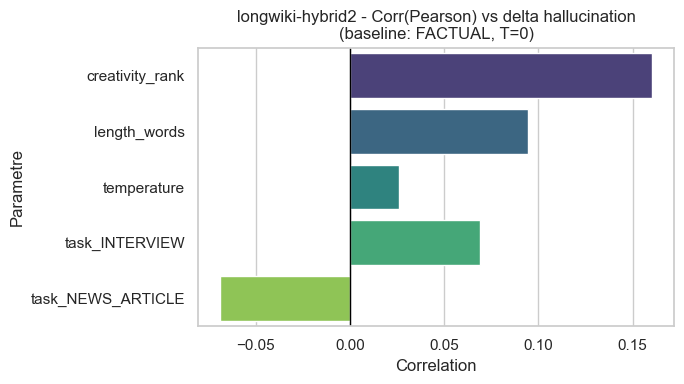

/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_20031/590447520.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




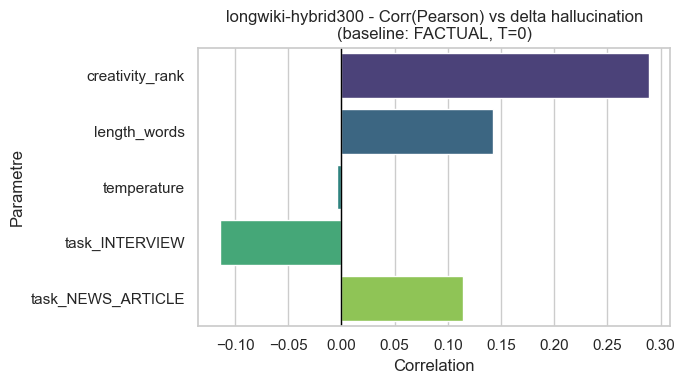

In [48]:
# Correlation avec hallucination (delta vs baseline FACTUAL & T=0) par dataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']
CREATIVITY_RANK = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
BASELINE_CREATIVE = 'FACTUAL'
BASELINE_TEMP = 0.0

# df_base doit contenir: root, hallucination_rate, length_words, temperature, creativity_level, task
# Exemple si tu utilises df_prompts:
df_base = df_prompts[df_prompts['metrics_available']].copy()

df_corr = df_base.copy()
df_corr['root_name'] = df_corr['root'].apply(lambda x: Path(str(x)).name)

for root_name, df_root in df_corr.groupby('root_name'):
    # Filtre tasks focus
    df_root = df_root[df_root['task'].isin(TASKS_FOCUS)].copy()
    if df_root.empty:
        print(f"[SKIP] {root_name}: aucune task dans TASKS_FOCUS")
        continue

    # Baseline FACTUAL + T=0
    df_ref = df_root[
        (df_root['creativity_level'] == BASELINE_CREATIVE) &
        (df_root['temperature'] == BASELINE_TEMP)
    ]
    if df_ref.empty:
        print(f"[SKIP] {root_name}: baseline FACTUAL@T0 absente")
        continue

    baseline = df_ref['hallucination_rate'].mean()
    df_root['delta_h'] = df_root['hallucination_rate'] - baseline

    # Encodage creativity
    df_root['creativity_rank'] = df_root['creativity_level'].map(CREATIVITY_RANK)

    # One-hot tasks
    task_dummies = pd.get_dummies(df_root['task'], prefix='task')

    corr_df = pd.concat([
        df_root[['delta_h', 'length_words', 'temperature', 'creativity_rank']],
        task_dummies
    ], axis=1)

    corr = (
        corr_df
        .corr(method='pearson')['delta_h']
        .drop('delta_h')
    )

    # Ordonner les facteurs principaux (et garder les tasks apres)
    ordered = ['creativity_rank', 'length_words', 'temperature']
    corr = corr.reindex([c for c in ordered if c in corr.index] + [c for c in corr.index if c not in ordered])

    # Graphique
    plt.figure(figsize=(7, 4))
    sns.barplot(x=corr.values, y=corr.index, orient='h', palette='viridis')
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{root_name} - Corr(Pearson) vs delta hallucination\n(baseline: FACTUAL, T=0)")
    plt.xlabel('Correlation')
    plt.ylabel('Parametre')
    plt.tight_layout()
    plt.show()


## 8) Correlations creativite <-> hallucination (robustes)

Ce bloc :
- agrege au niveau prompt_id pour eviter la pseudo-replication
- calcule Spearman/Pearson, IC95% (bootstrap / Fisher)
- p-values via permutation (recommande si n modeste)
- corrige la longueur (partial corr)
- applique FDR BH sur toutes les p-values


In [49]:
import numpy as np
import pandas as pd
from scipy import stats

try:
    from statsmodels.stats.multitest import multipletests
except Exception as e:
    multipletests = None
    print('statsmodels not available -> fallback FDR BH', e)

try:
    import pingouin as pg
except Exception as e:
    pg = None
    print('pingouin not available -> fallback partial corr', e)


def _get_stat_value(res):
    return float(res.statistic) if hasattr(res, 'statistic') else float(res[0])


def _get_p_value(res):
    return float(res.pvalue) if hasattr(res, 'pvalue') else float(res[1])


def _pick_length_col(df):
    for c in ('length_tokens', 'length_words', 'length_chars'):
        if c in df.columns:
            return c
    return None


def _fdr_bh(pvals):
    p = np.asarray(pvals, dtype=float)
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    p_adj = np.empty_like(q)
    p_adj[order] = np.clip(q, 0, 1)
    return p_adj


# -----------------------------
# 0) Pre-aggregation (important)
# -----------------------------

def aggregate_to_item_level(df: pd.DataFrame, group_cols) -> pd.DataFrame:
    """
    If you have k samples / item / condition, avoid pseudo-replication:
    -> aggregate to (prompt_id + condition) before correlating.
    """
    metric_cols = [
        c for c in (
            'creativity_rank', 'temperature',
            'hallucination_rate', 'support_rate', 'n_claims'
        ) if c in df.columns and c not in group_cols
    ]

    df2 = (
        df[group_cols + metric_cols]
        .groupby(group_cols, dropna=False)
        .mean(numeric_only=True)
        .reset_index()
    )
    return df2


# -----------------------------
# 1) CI bootstrap (generic)
# -----------------------------

def bootstrap_ci_corr(x: np.ndarray, y: np.ndarray, method: str, n_boot=2000, seed=0):
    """
    95% CI via bootstrap:
    - resample pairs (x_i, y_i) with replacement
    - recompute correlation at each bootstrap
    """
    rng = np.random.default_rng(seed)
    n = len(x)
    stats_boot = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        xb, yb = x[idx], y[idx]
        if method == 'spearman':
            r = _get_stat_value(stats.spearmanr(xb, yb))
        elif method == 'pearson':
            r = _get_stat_value(stats.pearsonr(xb, yb))
        else:
            raise ValueError("method must be 'spearman' or 'pearson'")
        if np.isfinite(r):
            stats_boot.append(r)

    if not stats_boot:
        return (np.nan, np.nan)
    lo, hi = np.quantile(stats_boot, [0.025, 0.975])
    return float(lo), float(hi)


# -----------------------------------------
# 2) p-value permutation (correlation)
# -----------------------------------------


def permutation_pvalue_corr(x: np.ndarray, y: np.ndarray, method: str, n_resamples=5000, seed=0):
    """
    Monte Carlo permutation test (avoids SciPy overflow warnings).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if method == 'spearman':
        x_use = stats.rankdata(x)
        y_use = stats.rankdata(y)
    elif method == 'pearson':
        x_use = x
        y_use = y
    else:
        raise ValueError

    x_use = x_use - x_use.mean()
    y_use = y_use - y_use.mean()
    denom = np.sqrt(np.sum(x_use ** 2) * np.sum(y_use ** 2))
    if denom == 0 or not np.isfinite(denom):
        return np.nan

    obs = float(np.dot(x_use, y_use) / denom)
    count = 0
    for _ in range(n_resamples):
        xp = rng.permutation(x_use)
        r = float(np.dot(xp, y_use) / denom)
        if abs(r) >= abs(obs):
            count += 1

    return (count + 1) / (n_resamples + 1)


# -----------------------------------------
# 3) Correlation + CI + p-value
# -----------------------------------------

def _fisher_ci(r, n, alpha=0.05):
    if n <= 3 or not np.isfinite(r):
        return (np.nan, np.nan)
    r = float(np.clip(r, -0.999999, 0.999999))
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    zcrit = stats.norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - zcrit * se)
    hi = np.tanh(z + zcrit * se)
    return float(lo), float(hi)


def corr_with_inference(df: pd.DataFrame, x_col: str, y_col: str, method='spearman',
                        ci_mode='bootstrap', n_boot=2000, n_perm=10000, seed=0, perm_if_n_lt=500):
    sub = df[[x_col, y_col]].dropna()
    x = sub[x_col].to_numpy()
    y = sub[y_col].to_numpy()
    n = len(x)
    if n < 4:
        return {'n': n, 'r': np.nan, 'p': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    if method == 'spearman':
        res = stats.spearmanr(x, y)
        r = _get_stat_value(res)
        if n < perm_if_n_lt:
            p = permutation_pvalue_corr(x, y, method='spearman', n_resamples=n_perm, seed=seed)
        else:
            p = _get_p_value(res)
        ci_low, ci_high = bootstrap_ci_corr(x, y, method='spearman', n_boot=n_boot, seed=seed)

    elif method == 'pearson':
        res = stats.pearsonr(x, y)
        r = _get_stat_value(res)
        p = _get_p_value(res)
        if hasattr(res, 'confidence_interval'):
            ci = res.confidence_interval(confidence_level=0.95)
            ci_low, ci_high = float(ci.low), float(ci.high)
        else:
            ci_low, ci_high = _fisher_ci(r, n)

    else:
        raise ValueError("method must be 'spearman' or 'pearson'")

    return {
        'n': n,
        'r': float(r),
        'p': float(p),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
        'r2': float(r * r),
    }


# -----------------------------------------
# 4) Partial correlation (control length)
# -----------------------------------------

def _residualize(y, z):
    z = np.asarray(z, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(np.unique(z[~np.isnan(z)])) < 2:
        return None
    A = np.column_stack([np.ones(len(z)), z])
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    y_hat = A @ coef
    return y - y_hat


def partial_corr_length(df: pd.DataFrame, x_col: str, y_col: str, length_col: str,
                        method='spearman', n_boot=2000, seed=0):
    sub = df[[x_col, y_col, length_col]].dropna()
    if len(sub) < 4:
        return {'n': len(sub), 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    if pg is not None:
        try:
            out = pg.partial_corr(data=sub, x=x_col, y=y_col, covar=length_col, method=method)
            r = float(out['r'].iloc[0])
            p = float(out['p-val'].iloc[0])
            ci_low, ci_high = out['CI95'].iloc[0]
            return {
                'n': int(out['n'].iloc[0]),
                'r_partial': r,
                'p_partial': p,
                'ci_low': float(ci_low),
                'ci_high': float(ci_high),
            }
        except Exception:
            # fall back below
            pass

    # Fallback: residualize then Pearson on residuals
    if method == 'spearman':
        x = stats.rankdata(sub[x_col])
        y = stats.rankdata(sub[y_col])
        z = stats.rankdata(sub[length_col])
    else:
        x = sub[x_col].to_numpy()
        y = sub[y_col].to_numpy()
        z = sub[length_col].to_numpy()

    rx = _residualize(x, z)
    ry = _residualize(y, z)
    if rx is None or ry is None:
        return {'n': len(sub), 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    res = stats.pearsonr(rx, ry)
    r = _get_stat_value(res)
    p = _get_p_value(res)
    ci_low, ci_high = bootstrap_ci_corr(rx, ry, method='pearson', n_boot=n_boot, seed=seed)

    return {
        'n': len(sub),
        'r_partial': float(r),
        'p_partial': float(p),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


# -----------------------------------------
# 5) Batch: all pairs + sub-groups
# -----------------------------------------

def run_correlation_suite(df: pd.DataFrame,
                          C_cols=('creativity_rank',),
                          H_cols=('hallucination_rate', 'support_rate', 'n_claims'),
                          group_cols=('root', 'task', 'model_name', 'temperature'),
                          length_col='length_words',
                          method='spearman',
                          min_n_partial=10,
                          n_boot=2000,
                          n_perm=10000,
                          seed=0,
                          perm_if_n_lt=500):
    results = []
    pvals_for_fdr = []

    # global
    for c in C_cols:
        for h in H_cols:
            base = corr_with_inference(df, c, h, method=method, n_boot=n_boot, n_perm=n_perm, seed=seed, perm_if_n_lt=perm_if_n_lt)
            pc = partial_corr_length(df, c, h, length_col, method=method, n_boot=n_boot, seed=seed) if length_col in df.columns else {
                'n': base['n'], 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan
            }
            row = {'scope': 'global', 'group_key': 'ALL', 'x': c, 'y': h, **base, **pc}
            results.append(row)
            pvals_for_fdr.append(row['p'])

    # by groups
    for keys, g in df.groupby(list(group_cols), dropna=False):
        group_key = '|'.join(map(str, keys))
        for c in C_cols:
            for h in H_cols:
                base = corr_with_inference(g, c, h, method=method, n_boot=n_boot, n_perm=n_perm, seed=seed, perm_if_n_lt=perm_if_n_lt)
                if base['n'] >= min_n_partial and length_col in g.columns:
                    pc = partial_corr_length(g, c, h, length_col, method=method, n_boot=n_boot, seed=seed)
                else:
                    pc = {'n': base['n'], 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}
                row = {'scope': 'group', 'group_key': group_key, 'x': c, 'y': h, **base, **pc}
                results.append(row)
                pvals_for_fdr.append(row['p'])

    res_df = pd.DataFrame(results)

    # -----------------------------------------
    # 6) Multiple testing correction (FDR BH)
    # -----------------------------------------
    pvals = np.asarray(pvals_for_fdr, dtype=float)
    p_fdr = np.full_like(pvals, np.nan, dtype=float)
    mask = np.isfinite(pvals)
    if mask.any():
        if multipletests is not None:
            _, p_fdr[mask], _, _ = multipletests(pvals[mask], alpha=0.05, method='fdr_bh')
        else:
            p_fdr[mask] = _fdr_bh(pvals[mask])
    res_df['p_fdr_bh'] = p_fdr

    return res_df


# -----------------------------
# 7) Example usage (adapt columns)
# -----------------------------
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip correlation suite')
else:
    df_corr = df_prompts[df_prompts['metrics_available']].copy()

    # Map creativity_level -> numeric rank
    if 'creativity_level' in df_corr.columns:
        creativity_rank = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
        df_corr['creativity_rank'] = df_corr['creativity_level'].map(creativity_rank)

    # Choose length column (tokens if available, else words)
    length_col = _pick_length_col(df_corr) or 'length_words'

    # Aggregate to item level (prompt_id + condition)
    group_cols = [
        c for c in (
            'prompt_id', 'prompt_set_id', 'instance_set_id',
            'root', 'task', 'model_name', 'temperature'
        ) if c in df_corr.columns
    ]
    df_item = aggregate_to_item_level(df_corr, group_cols=group_cols)

    # Define which columns to correlate
    C_cols = [c for c in ('creativity_rank',) if c in df_item.columns]
    H_cols = [c for c in ('hallucination_rate', 'support_rate', 'n_claims') if c in df_item.columns]
    group_cols = [c for c in ('root', 'task', 'model_name', 'temperature') if c in df_item.columns]

    
    CORR_N_BOOT = 1000
    CORR_N_PERM = 2000
    PERM_IF_N_LT = 500

    res_corr = run_correlation_suite(
        df_item,
        C_cols=C_cols,
        H_cols=H_cols,
        group_cols=group_cols,
        length_col=length_col,
        method='spearman',
        n_boot=CORR_N_BOOT,
        n_perm=CORR_N_PERM,
        seed=7,
        perm_if_n_lt=PERM_IF_N_LT,
    )

    display(res_corr.head(20))

    # Optional export
    # res_corr.to_csv(ARTIFACTS_DIR / 'corr_creativity_hallucination.csv', index=False)


,scope,group_key,x,y,n,r,p,ci_low,ci_high,r2,r_partial,p_partial,p_fdr_bh
0,global,ALL,creativity_rank,hallucination_rate,5437,0.218030,1.636675e-59,NaN,NaN,0.047537,NaN,NaN,1.031105e-57
1,global,ALL,creativity_rank,support_rate,5437,-0.218030,1.636675e-59,NaN,NaN,0.047537,NaN,NaN,1.031105e-57
2,global,ALL,creativity_rank,n_claims,5437,-0.028043,3.866576e-02,NaN,NaN,0.000786,NaN,NaN,1.132997e-01
3,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,147,0.266704,1.499250e-03,NaN,NaN,0.071131,NaN,NaN,5.724411e-03
4,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,support_rate,147,-0.266704,1.499250e-03,NaN,NaN,0.071131,NaN,NaN,5.724411e-03
5,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,n_claims,147,0.098273,2.338831e-01,NaN,NaN,0.009658,NaN,NaN,4.831027e-01
6,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,147,0.276186,9.995002e-04,NaN,NaN,0.076279,NaN,NaN,4.342656e-03
7,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,support_rate,147,-0.276186,9.995002e-04,NaN,NaN,0.076279,NaN,NaN,4.342656e-03
8,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,n_claims,147,0.034910,6.631684e-01,NaN,NaN,0.001219,NaN,NaN,8.264618e-01
9,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,146,0.235639,3.498251e-03,NaN,NaN,0.055526,NaN,NaN,1.191296e-02


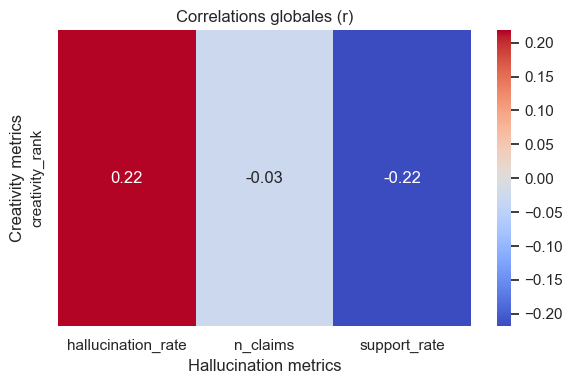

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'res_corr' not in globals() or res_corr is None or res_corr.empty:
    print('res_corr empty - skip correlation plot')
else:
    df_viz = res_corr[res_corr['scope'] == 'global'].copy()
    if df_viz.empty:
        print('No global correlations to plot')
    else:
        pivot = df_viz.pivot(index='x', columns='y', values='r')
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Correlations globales (r)')
        plt.xlabel('Hallucination metrics')
        plt.ylabel('Creativity metrics')
        plt.tight_layout()
        plt.show()


In [ ]:

    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    if 'df_prompts' not in globals() or df_prompts.empty:
        print('df_prompts empty - skip parameter comparison')
    else:
        df_cmp = df_prompts[df_prompts['metrics_available']].copy()

        if 'creativity_level' in df_cmp.columns:
            creativity_rank = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
            df_cmp['creativity_rank'] = df_cmp['creativity_level'].map(creativity_rank)

        base_cols = ['hallucination_rate']
        for c in ('temperature', 'length_words', 'creativity_rank'):
            if c in df_cmp.columns:
                base_cols.append(c)

        base = df_cmp[base_cols + [c for c in ('model_name', 'task', 'root') if c in df_cmp.columns]].copy()

        # --- Numeric params correlations (temperature, length_words, creativity_rank)
        num_cols = [c for c in ('temperature', 'length_words', 'creativity_rank') if c in base.columns]
        if num_cols:
            corr_num = base[['hallucination_rate'] + num_cols].corr(method='spearman')['hallucination_rate']
            corr_num = corr_num.drop('hallucination_rate').sort_values()
            plt.figure(figsize=(8, max(3, 0.25 * len(corr_num))))
            sns.barplot(x=corr_num.values, y=corr_num.index, palette='coolwarm')
            plt.axvline(0, color='black', linewidth=1)
            plt.title('Correlation (Spearman) vs hallucination_rate
Parametres numeriques')
            plt.xlabel('Spearman r')
            plt.ylabel('Parametre')
            plt.tight_layout()
            plt.show()

        # --- Categorical hyperparameter: MODEL (each value is a level)
        if 'model_name' in base.columns:
            d_model = pd.get_dummies(base['model_name'], prefix='model')
            corr_model = pd.concat([base[['hallucination_rate']], d_model], axis=1).corr(method='spearman')['hallucination_rate']
            corr_model = corr_model.drop('hallucination_rate').sort_values()
            plt.figure(figsize=(8, max(3, 0.25 * len(corr_model))))
            sns.barplot(x=corr_model.values, y=corr_model.index, palette='coolwarm')
            plt.axvline(0, color='black', linewidth=1)
            plt.title('Correlation (Spearman) vs hallucination_rate
Hyperparametre MODEL (valeurs)')
            plt.xlabel('Spearman r')
            plt.ylabel('Model')
            plt.tight_layout()
            plt.show()

        # --- Categorical hyperparameter: TASK (each value is a level)
        if 'task' in base.columns:
            d_task = pd.get_dummies(base['task'], prefix='task')
            corr_task = pd.concat([base[['hallucination_rate']], d_task], axis=1).corr(method='spearman')['hallucination_rate']
            corr_task = corr_task.drop('hallucination_rate').sort_values()
            plt.figure(figsize=(8, max(3, 0.25 * len(corr_task))))
            sns.barplot(x=corr_task.values, y=corr_task.index, palette='coolwarm')
            plt.axvline(0, color='black', linewidth=1)
            plt.title('Correlation (Spearman) vs hallucination_rate
Hyperparametre TASK (valeurs)')
            plt.xlabel('Spearman r')
            plt.ylabel('Task')
            plt.tight_layout()
            plt.show()

        # Optional: compare by dataset/root
        if 'root' in base.columns:
            # numeric by root
            if num_cols:
                rows = []
                for root, sub in base.groupby('root'):
                    if sub['hallucination_rate'].notna().sum() < 5:
                        continue
                    cnum = sub[['hallucination_rate'] + num_cols].corr(method='spearman')['hallucination_rate']
                    cnum = cnum.drop('hallucination_rate')
                    for k, v in cnum.items():
                        rows.append({'root': str(root), 'param': k, 'r': v})
                if rows:
                    corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                    plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                    sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                    plt.title('Correlation (Spearman) vs hallucination_rate par root
Parametres numeriques')
                    plt.xlabel('root')
                    plt.ylabel('Parametre')
                    plt.tight_layout()
                    plt.show()

            # model by root
            if 'model_name' in base.columns:
                rows = []
                for root, sub in base.groupby('root'):
                    if sub['hallucination_rate'].notna().sum() < 5:
                        continue
                    d_model = pd.get_dummies(sub['model_name'], prefix='model')
                    cmod = pd.concat([sub[['hallucination_rate']], d_model], axis=1).corr(method='spearman')['hallucination_rate']
                    cmod = cmod.drop('hallucination_rate')
                    for k, v in cmod.items():
                        rows.append({'root': str(root), 'param': k, 'r': v})
                if rows:
                    corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                    plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                    sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                    plt.title('Correlation (Spearman) vs hallucination_rate par root
Hyperparametre MODEL')
                    plt.xlabel('root')
                    plt.ylabel('Model')
                    plt.tight_layout()
                    plt.show()

            # task by root
            if 'task' in base.columns:
                rows = []
                for root, sub in base.groupby('root'):
                    if sub['hallucination_rate'].notna().sum() < 5:
                        continue
                    d_task = pd.get_dummies(sub['task'], prefix='task')
                    ctask = pd.concat([sub[['hallucination_rate']], d_task], axis=1).corr(method='spearman')['hallucination_rate']
                    ctask = ctask.drop('hallucination_rate')
                    for k, v in ctask.items():
                        rows.append({'root': str(root), 'param': k, 'r': v})
                if rows:
                    corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                    plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                    sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                    plt.title('Correlation (Spearman) vs hallucination_rate par root
Hyperparametre TASK')
                    plt.xlabel('root')
                    plt.ylabel('Task')
                    plt.tight_layout()
                    plt.show()


SyntaxError: unterminated string literal (detected at line 54) (4129823909.py, line 54)

## 9) Exports (catalogue + metriques + comparaisons)


In [ ]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Export run index
if 'df_runs' in globals() and not df_runs.empty:
    df_runs.to_csv(ARTIFACTS_DIR / 'run_index.csv', index=False)
    print('Exported:', ARTIFACTS_DIR / 'run_index.csv')

# Export prompt metrics
if 'df_prompts' in globals() and not df_prompts.empty:
    try:
        df_prompts.to_parquet(ARTIFACTS_DIR / 'prompt_metrics.parquet', index=False)
        print('Exported:', ARTIFACTS_DIR / 'prompt_metrics.parquet')
    except Exception as e:
        warn(f"Parquet export failed ({e}); falling back to CSV")
        df_prompts.to_csv(ARTIFACTS_DIR / 'prompt_metrics.csv', index=False)
        print('Exported:', ARTIFACTS_DIR / 'prompt_metrics.csv')

# Export comparisons
if COMPARISONS:
    df_comp = pd.DataFrame(COMPARISONS)
    df_comp.to_csv(ARTIFACTS_DIR / 'comparisons.csv', index=False)
    print('Exported:', ARTIFACTS_DIR / 'comparisons.csv')
else:
    print('No comparisons to export.')


Exported: artifacts/run_index.csv
Exported: artifacts/prompt_metrics.parquet
Exported: artifacts/comparisons.csv
